## Project Setup (Colab)

Run these cells from top to bottom to build a stable, reproducible environment.

In [1]:
# # ======================================
# # 🔧 INSTALL DEPENDENCIES (run once, then restart kernel if prompted)
# # ======================================
# %%capture
# %pip install -q --force-reinstall     numpy==1.26.4     scipy==1.13.1     torch==2.4.1     torchaudio==2.4.1     coqui-tts==0.23.1     pandas==2.2.3     matplotlib==3.9.2     scikit-learn==1.5.2     tqdm==4.66.5

# # After running this cell, restart the runtime by going to "Runtime" -> "Restart session" in the Colab menu.

In [2]:
# !pip uninstall -y numpy pandas scipy
# !pip install --no-cache-dir --force-reinstall numpy==1.26.4 pandas==2.2.3 scipy==1.13.1
# !pip install coqui-tts==0.23.1

In [3]:
# ======================================
# 📦 IMPORT LIBRARIES
# ======================================
import os, sys, glob, random, shutil, csv, itertools, threading, platform, importlib
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor, as_completed
from collections import defaultdict

# Core scientific stack
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from tqdm import tqdm

# Machine learning / audio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
from torch.utils.data import DataLoader, Dataset

from sklearn.metrics import classification_report
from sklearn.manifold import TSNE

# Coqui Text-to-Speech
from TTS.api import TTS

%matplotlib inline


/usr/local/lib/python3.12/dist-packages/jieba/_compat.py:18: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [4]:
# ======================================
# 🎯 REPRODUCIBILITY (Seed everything)
# ======================================
import random
import numpy as _np
import torch as _torch

SEED = 42
random.seed(SEED)
_np.random.seed(SEED)
_torch.manual_seed(SEED)
if _torch.cuda.is_available():
    _torch.cuda.manual_seed_all(SEED)

print(f"Seed set to {SEED}")


Seed set to 42


In [5]:
# ======================================
# ✅ ENVIRONMENT CHECK
# ======================================
import platform
print("Environment is ready!")
print(f"Python: {platform.python_version()}")
print(f"NumPy: {np.__version__} | SciPy: {scipy.__version__}")
print(f"Torch: {torch.__version__} | Torchaudio: {torchaudio.__version__}")
print(f"Pandas: {pd.__version__}")
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA device:", torch.cuda.get_device_name(0))


Environment is ready!
Python: 3.12.12
NumPy: 1.26.4 | SciPy: 1.13.1
Torch: 2.4.1+cu121 | Torchaudio: 2.4.1+cu121
Pandas: 2.2.3
CUDA available: True
CUDA device: Tesla T4


In [6]:
# ======================================
# 🧊 FREEZE ENVIRONMENT (lock file + system info)
# ======================================
import os, json, platform
import numpy as _numpy
import scipy as _scipy
import torch as _torch
import pandas as _pandas
from google.colab import drive
drive.mount('/content/drive')

LOCK_TXT = "/content/requirements_lock.txt"
LOCK_JSON = "/content/env_lock.json"

# Freeze exact package versions
!pip freeze > "$LOCK_TXT"

# Save system info + core libs versions
env_info = {
    "python": platform.python_version(),
    "platform": platform.platform(),
    "cuda_available": _torch.cuda.is_available(),
    "cuda_device": (_torch.cuda.get_device_name(0) if _torch.cuda.is_available() else None),
    "versions": {
        "numpy": _numpy.__version__,
        "scipy": _scipy.__version__,
        "torch": _torch.__version__,
        "pandas": _pandas.__version__,
    }
}
with open(LOCK_JSON, "w") as f:
    json.dump(env_info, f, indent=2)

print(f"Saved lockfile to: {LOCK_TXT}")
print(f"Saved environment info to: {LOCK_JSON}")

# If Drive is mounted, also copy there for persistence
drive_base = "/content/drive/MyDrive/ColabEnvLocks"
if os.path.exists("/content/drive"):
    os.makedirs(drive_base, exist_ok=True)
    !cp -f "$LOCK_TXT" "$drive_base/requirements_lock.txt"
    !cp -f "$LOCK_JSON" "$drive_base/env_lock.json"
    print(f"Also copied to Drive: {drive_base}")
else:
    print("Google Drive is not mounted; skipping Drive backup.")


Mounted at /content/drive
Saved lockfile to: /content/requirements_lock.txt
Saved environment info to: /content/env_lock.json
Also copied to Drive: /content/drive/MyDrive/ColabEnvLocks


In [7]:
# ======================================
# 🔁 RESTORE ENV FROM LOCK (use on fresh runtimes)
# ======================================
%%capture
# Prefer Drive lock if available, else local
LOCK_TXT = "/content/drive/MyDrive/ColabEnvLocks/requirements_lock.txt"
FALLBACK_LOCK = "/content/requirements_lock.txt"
import os
lock_to_use = LOCK_TXT if os.path.exists(LOCK_TXT) else FALLBACK_LOCK
print(f"Installing from lock: {lock_to_use}")
%pip install -q --no-deps -r "$lock_to_use"


In [8]:

# ======================================
# ⬇️ OPTIONAL: PRE-DOWNLOAD TTS MODEL WEIGHTS (persist to Drive if mounted)
# ======================================
from TTS.api import TTS
import os

MODEL_NAME = "tts_models/en/ljspeech/tacotron2-DDC"  # change if you need a different model
LOCAL_DIR = "/content/models/tts"
os.makedirs(LOCAL_DIR, exist_ok=True)

# Instantiate once to trigger download into cache; also synthesize a tiny file to ensure weights are present
tts = TTS(model_name=MODEL_NAME, progress_bar=False, gpu=torch.cuda.is_available())
tts.tts_to_file(text="setup", file_path=f"{LOCAL_DIR}/_warmup.wav")
print("Model ready:", MODEL_NAME)

# If Drive is mounted, copy cache for persistence
if os.path.exists("/content/drive"):
    DRIVE_DIR = "/content/drive/MyDrive/ColabModels/tts"
    os.makedirs(DRIVE_DIR, exist_ok=True)
    print("Drive detected. Consider syncing ~/.local/share/tts to Drive for full persistence.")
else:
    print("Drive not mounted — model will be cached only in this runtime.")


/usr/local/lib/python3.12/dist-packages/TTS/api.py:71: UserWarning: `gpu` will be deprecated. Please use `tts.to(device)` instead.
  warnings.warn("`gpu` will be deprecated. Please use `tts.to(device)` instead.")
/usr/local/lib/python3.12/dist-packages/TTS/utils/io.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use

Model ready: tts_models/en/ljspeech/tacotron2-DDC
Drive detected. Consider syncing ~/.local/share/tts to Drive for full persistence.


In [9]:
# ======================================
# 📦 OPTIONAL: EXTRACT ALL ZIP DATASETS IN /content
# ======================================
import zipfile, glob, os
DATA_DIR = "/content/data"
os.makedirs(DATA_DIR, exist_ok=True)

zips = glob.glob("/content/*.zip")
for z in zips:
    print("Extracting:", z)
    with zipfile.ZipFile(z, 'r') as zip_ref:
        zip_ref.extractall(DATA_DIR)

print("Done. Files in data dir:")
for root, dirs, files in os.walk(DATA_DIR):
    for f in files[:50]:
        print(os.path.join(root, f))


Done. Files in data dir:


## extract_data


In [ ]:
# import shutil
# import os

# # הנתיב לתיקייה שנוצרה בהרצה הקודמת
# destination_folder = "/content/vctk_full"

# # בדיקה אם התיקייה קיימת, ואז מחיקה
# if os.path.exists(destination_folder):
#     shutil.rmtree(destination_folder)
#     print(f" התיקייה '{destination_folder}' נמחקה בהצלחה.")
# else:
#     print(f"ℹ התיקייה '{destination_folder}' לא קיימת, אין מה למחוק.")


In [10]:
import zipfile
import os
import shutil
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# List contents to verify paths (optional)
root_path = '/content/drive/My Drive/'
print("Contents of 'My Drive':", os.listdir(root_path))

subfolder_path = '/content/drive/My Drive/Colab Notebooks/'
print("Contents of 'Colab Notebooks':", os.listdir(subfolder_path))

# Define paths
zip_file = "/content/drive/My Drive/Colab Notebooks/archive.zip"  # Path to your ZIP file
destination_folder = "/content/vctk_samples"  # Where to extract selected data
wanted_speakers = ["p225", "p226", "p227", "p228"]  # Select specific speakers

# Check if the ZIP file exists
if os.path.isfile(zip_file):
    print(" ZIP file found:", zip_file)
else:
    raise FileNotFoundError(f" ZIP file not found: {zip_file}")

# Create destination folder if it doesn't exist
os.makedirs(destination_folder, exist_ok=True)

# Selectively extract only desired speaker folders from the ZIP
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    extracted_files = 0
    for file in zip_ref.namelist():
        if any(f"VCTK-Corpus/wav48/{spk}/" in file or f"VCTK-Corpus/txt/{spk}/" in file for spk in wanted_speakers):
            # Ensure directory structure is preserved
            target_path = os.path.join(destination_folder, file)
            os.makedirs(os.path.dirname(target_path), exist_ok=True)
            with zip_ref.open(file) as source, open(target_path, 'wb') as target:
                shutil.copyfileobj(source, target)
            extracted_files += 1

print(f"\n Extraction complete: {extracted_files} files were extracted.")
print(f" Extracted data is available in: {destination_folder}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Contents of 'My Drive': ['Colab Notebooks', 'Deep learning', 'ColabEnvLocks', 'ColabModels', 'Colab_Data']
Contents of 'Colab Notebooks': ['archive.zip', 'fake_audio.zip', 'Copy of Welcome To Colab', 'Untitled0.ipynb', 'Untitled1.ipynb', 'Untitled2.ipynb', 'FinalProjectCS.ipynb', 'FinalProjectCS_reset_setup_May_Rotem.ipynb']
 ZIP file found: /content/drive/My Drive/Colab Notebooks/archive.zip

 Extraction complete: 2684 files were extracted.
 Extracted data is available in: /content/vctk_samples


## Installations


In [11]:
!apt-get install -y espeak-ng

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  espeak-ng-data libespeak-ng1 libpcaudio0 libsonic0
The following NEW packages will be installed:
  espeak-ng espeak-ng-data libespeak-ng1 libpcaudio0 libsonic0
0 upgraded, 5 newly installed, 0 to remove and 41 not upgraded.
Need to get 4,526 kB of archives.
After this operation, 11.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libpcaudio0 amd64 1.1-6build2 [8,956 B]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libsonic0 amd64 0.2.0-11build1 [10.3 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 espeak-ng-data amd64 1.50+dfsg-10ubuntu0.1 [3,956 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libespeak-ng1 amd64 1.50+dfsg-10ubuntu0.1 [207 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 espeak-ng amd64 1.50+dfsg-1

## Creating Fake Audio (No Need to run now)

In [ ]:
# import os
# from pathlib import Path
# from concurrent.futures import ThreadPoolExecutor, as_completed
# import threading
# import torch

# from TTS.api import TTS

# # =========================
# # CONFIG (VC Version)
# # =========================
# # 1) Input text files (one .txt per utterance - needed for content)
# TEXT_ROOT = Path("/content/vctk_samples/VCTK-Corpus/VCTK-Corpus/txt")

# # 2) Real audio folder (source audio files to be converted)
# REAL_AUDIO_ROOT = Path("/content/vctk_samples/VCTK-Corpus/VCTK-Corpus/wav48")

# # 3) <<< NEW >>> Output folder for the VOICE CONVERTED real audio
# OUT_ROOT_VC = Path("/content/vctk_samples/VCTK-Corpus/VCTK-Corpus/vc_wav48_xtts") # Changed path
# OUT_ROOT_VC.mkdir(parents=True, exist_ok=True)

# # 4) Language to synthesize in
# LANGUAGE = "en"

# # 5) Concurrency settings
# GPU_AVAILABLE = torch.cuda.is_available()
# MAX_WORKERS = 1 if GPU_AVAILABLE else 4 # Keep 1 for GPU

# # =========================
# # MODEL LOADING (Only XTTS needed now)
# # =========================
# print("Loading XTTS v2 model...")
# tts_xtts = TTS(model_name="tts_models/multilingual/multi-dataset/xtts_v2", progress_bar=True)
# device = "cuda" if GPU_AVAILABLE else "cpu"
# tts_xtts.to(device)
# print(f"XTTS is running on: {device}")

# # Mutex for model calls if needed (usually only needed if MAX_WORKERS > 1 on CPU)
# synth_lock = threading.Lock() if MAX_WORKERS > 1 else None

# # =========================
# # HELPERS (find_matching_real_wav remains the same)
# # =========================
# def find_matching_real_wav(real_root: Path, subdir: str, txt_filename: str) -> Path | None:
#     """
#     Try to find the real WAV that matches the text file stem.
#     (Code remains exactly the same as before)
#     """
#     stem = Path(txt_filename).stem
#     parts = stem.split("_")
#     if parts and not parts[0].startswith("p"):
#         parts[0] = "p" + parts[0]
#     norm_stem = "_".join(parts)

#     cand1 = real_root / subdir / f"{norm_stem}.wav"
#     if cand1.exists():
#         return cand1
#     cand2 = real_root / subdir / f"{stem}.wav"
#     if cand2.exists():
#         return cand2
#     subdir_path = real_root / subdir
#     if subdir_path.is_dir():
#         for fn in os.listdir(subdir_path):
#             if not fn.lower().endswith(".wav"): continue
#             if norm_stem in fn or stem in fn:
#                 return subdir_path / fn
#     return None

# def synth_xtts_vc(text: str, speaker_wav: Path, out_path: Path, language: str = "en"):
#     """
#     Synthesize using XTTS v2, using the real wav as the speaker reference.
#     (Function renamed slightly for clarity, code is the same synth_xtts)
#     """
#     if synth_lock:
#         with synth_lock:
#             tts_xtts.tts_to_file(text=text, file_path=str(out_path), speaker_wav=str(speaker_wav), language=language)
#     else:
#         tts_xtts.tts_to_file(text=text, file_path=str(out_path), speaker_wav=str(speaker_wav), language=language)

# # =========================
# # <<< MODIFIED >>> Process Function
# # =========================
# def process_one_vc(text_path: Path, out_subdir: Path):
#     """
#     Process a single text file to perform Voice Conversion on the corresponding real audio:
#       - Read text
#       - Find matching real WAV (THIS IS NOW THE SOURCE AUDIO *AND* VOICE REFERENCE)
#       - Synthesize using XTTS with the text and real_wav
#     """
#     text = text_path.read_text(encoding="utf-8").strip()
#     if not text:
#         return f"[SKIP VC] Empty text: {text_path.name}"

#     # Find the matching real wav in REAL_AUDIO_ROOT/<subdir>/
#     subdir = text_path.parent.name # Assumes text files are organized like 'txt/p225/*.txt'
#     real_wav = find_matching_real_wav(REAL_AUDIO_ROOT, subdir, text_path.name)

#     # <<< CHANGED >>> If no real wav found, skip this file entirely
#     if not real_wav or not real_wav.exists():
#         return f"[SKIP VC] No matching real WAV found for: {text_path.name} in {REAL_AUDIO_ROOT / subdir}"

#     # Build simple output path (just the original stem)
#     out_name = f"{text_path.stem}.wav" # Simplified filename
#     out_path = out_subdir / out_name

#     # Synthesize using the text content and the real wav as speaker reference
#     msg = f"[VC XTTS] {text_path.name} (using text) + {real_wav.name} (as voice) -> {out_name}"
#     synth_xtts_vc(text=text, speaker_wav=real_wav, out_path=out_path, language=LANGUAGE)
#     return msg

# # =========================
# # BUILD JOBS (Iterate through TEXT files to get utterance list and content)
# # =========================
# jobs_vc = []
# # Ensure TEXT_ROOT points to the directory containing speaker subdirs like 'p225', 'p226', etc.
# if not any(d.name.startswith('p') for d in TEXT_ROOT.iterdir() if d.is_dir()):
#      print(f"[WARNING] TEXT_ROOT ({TEXT_ROOT}) does not seem to contain speaker subdirectories (pXXX). Adjust if needed.")
#      # If text files are directly under TEXT_ROOT (no speaker subdirs):
#      # out_subdir_vc = OUT_ROOT_VC # Single output dir
#      # out_subdir_vc.mkdir(parents=True, exist_ok=True)
#      # for fn in os.listdir(TEXT_ROOT):
#      #    if fn.lower().endswith(".txt"):
#      #       jobs_vc.append((TEXT_ROOT / fn, out_subdir_vc))
# else:
#     # Original logic assuming speaker subdirs under TEXT_ROOT
#     for subdir in os.listdir(TEXT_ROOT):
#         subdir_path = TEXT_ROOT / subdir
#         if not subdir_path.is_dir():
#             continue

#         out_subdir_vc = OUT_ROOT_VC / subdir # Create matching speaker subdir in output
#         out_subdir_vc.mkdir(parents=True, exist_ok=True)

#         for fn in os.listdir(subdir_path):
#             if not fn.lower().endswith(".txt"):
#                 continue
#             jobs_vc.append((subdir_path / fn, out_subdir_vc))


# print(f"Found {len(jobs_vc)} text files for VC processing.")

# # =========================
# # RUN VC
# # =========================
# if not jobs_vc:
#     print("No VC jobs found. Check TEXT_ROOT structure and content.")
# else:
#     print(f"Starting Voice Conversion synthesis with MAX_WORKERS={MAX_WORKERS} (device={device})")
#     with ThreadPoolExecutor(max_workers=MAX_WORKERS) as ex:
#         futs_vc = [ex.submit(process_one_vc, text_path, out_dir) for (text_path, out_dir) in jobs_vc]
#         # Use tqdm for progress bar
#         from tqdm import tqdm
#         for fut in tqdm(as_completed(futs_vc), total=len(futs_vc)):
#             try:
#                 info = fut.result()
#                 # Optionally print less info inside the loop for cleaner progress
#                 # print(info)
#             except Exception as e:
#                 print(f"\n[ERROR VC] {repr(e)}") # Add newline if tqdm is used

# print(f"\nDone. Voice Converted ('real' with XTTS signature) audio saved under: {OUT_ROOT_VC}")

## Extracting the fake audio

In [12]:
import zipfile
import os
import shutil
from google.colab import drive

# Define paths
zip_file = "/content/drive/My Drive/Colab Notebooks/fake_audio.zip"  # Path to your ZIP file
destination_folder = "/content/vctk_samples/VCTK-Corpus/VCTK-Corpus/fake_audio"  # Where to extract selected data

# Example: define the speakers you want to extract
wanted_speakers = ["p225", "p226","p227","p228"]  # change this list as needed

# Check if the ZIP file exists
if os.path.isfile(zip_file):

    print(" ZIP file found:", zip_file)
else:
    raise FileNotFoundError(f" ZIP file not found: {zip_file}")

# Create destination folder if it doesn't exist
os.makedirs(destination_folder, exist_ok=True)

# Selectively extract only desired speaker folders from the ZIP
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    extracted_files = 0
    for file in zip_ref.namelist():
        if any(f"{spk}/" in file for spk in wanted_speakers):
            target_path = os.path.join(destination_folder, file)

            # If this entry is a directory → skip it
            if file.endswith('/'):
                os.makedirs(target_path, exist_ok=True)
                continue

            # Ensure directory structure is preserved
            os.makedirs(os.path.dirname(target_path), exist_ok=True)

            # Copy file content
            with zip_ref.open(file) as source, open(target_path, 'wb') as target:
                shutil.copyfileobj(source, target)
            extracted_files += 1

print(f"Extracted {extracted_files} files for speakers: {wanted_speakers}")


 ZIP file found: /content/drive/My Drive/Colab Notebooks/fake_audio.zip
Extracted 1342 files for speakers: ['p225', 'p226', 'p227', 'p228']


## Importing libraries

In [13]:
!nvidia-smi -L || echo "No GPU"

GPU 0: Tesla T4 (UUID: GPU-49ac0dd5-2f88-51b1-5635-5e7bcd2e0516)


In [14]:
%%bash
set -euo pipefail

# --- Clone CLAD fresh (idempotent: remove existing dir if present) ---
# remove previous clone to ensure a clean edit of requirements
rm -rf CLAD
git clone https://github.com/CLAD23/CLAD.git

# --- Normalize requirements for Python 3.12 (single source of truth) ---
cp CLAD/requirements.txt CLAD/requirements.bak

# 1) Remove torch lines (Torch is installed manually for the correct CUDA wheel)
sed -i '/^torch==/d; /^torchvision==/d; /^torchaudio==/d' CLAD/requirements.txt

# 2) Core pins for Py3.12 + Numba 0.60.0 (compatible with llvmlite 0.43.0 and NumPy 1.26.4)
#    These ensure no NumPy 2.x is pulled by accident.
if grep -q '^numpy' CLAD/requirements.txt; then
  sed -i 's/^numpy==.*/numpy==1.26.4/' CLAD/requirements.txt
else
  sed -i '1i numpy==1.26.4' CLAD/requirements.txt
fi

if grep -q '^numba' CLAD/requirements.txt; then
  sed -i 's/^numba==.*/numba==0.60.0/' CLAD/requirements.txt
else
  sed -i '1i numba==0.60.0' CLAD/requirements.txt
fi

if grep -q '^llvmlite' CLAD/requirements.txt; then
  sed -i 's/^llvmlite==.*/llvmlite==0.43.0/' CLAD/requirements.txt
else
  sed -i '1i llvmlite==0.43.0' CLAD/requirements.txt
fi

# 3) Stable Matplotlib on Py3.12
if grep -q '^matplotlib' CLAD/requirements.txt; then
  sed -i 's/^matplotlib==.*/matplotlib==3.8.4/' CLAD/requirements.txt
else
  sed -i '1i matplotlib==3.8.4' CLAD/requirements.txt
fi

# 4) Librosa must satisfy coqui-tts (>=0.11.0); keep it permissive to avoid conflicts
if grep -q '^librosa' CLAD/requirements.txt; then
  sed -i 's/^librosa.*/librosa>=0.11.0/' CLAD/requirements.txt
else
  sed -i '1i librosa>=0.11.0' CLAD/requirements.txt
fi

# 5) Pin OpenCV to builds compatible with NumPy 1.26.x (avoid NumPy 2.x constraint)
#    Only modify if opencv lines exist (do not add if the project doesn't use it).
grep -q '^opencv-python' CLAD/requirements.txt && sed -i 's/^opencv-python==.*/opencv-python==4.9.0.80/' CLAD/requirements.txt || true
grep -q '^opencv-contrib-python' CLAD/requirements.txt && sed -i 's/^opencv-contrib-python==.*/opencv-contrib-python==4.9.0.80/' CLAD/requirements.txt || true

# 6) Pin spaCy/Thinc to versions that work with NumPy 1.x (only if present)
grep -q '^thinc' CLAD/requirements.txt && sed -i 's/^thinc==.*/thinc==8.2.2/' CLAD/requirements.txt || true
grep -q '^spacy' CLAD/requirements.txt && sed -i 's/^spacy==.*/spacy==3.7.4/' CLAD/requirements.txt || true

echo "===== Updated CLAD/requirements.txt ====="
sed -n '1,250p' CLAD/requirements.txt

# --- Upgrade pip to avoid resolver quirks ---
python -m pip install -U pip

# --- Install PyTorch 2.3.1 CUDA 12.1 (use CPU wheels by removing the index line if no GPU) ---
python -m pip install --index-url https://download.pytorch.org/whl/cu121 \
  torch==2.3.1 torchvision==0.18.1 torchaudio==2.3.1

# --- Install remaining CLAD dependencies from the single normalized requirements file ---
python -m pip install -r CLAD/requirements.txt

# --- System library for soundfile/librosa WAV I/O (safe to install always) ---
apt-get update -y
apt-get install -y libsndfile1

echo "===== DONE: Environment pinned for Python 3.12 ====="
python -V
python - <<'PY'
import sys, numpy, numba, llvmlite, matplotlib
import importlib
print("Python:", sys.version.split()[0])
print("NumPy:", numpy.__version__)
print("Numba:", numba.__version__)
print("llvmlite:", llvmlite.__version__)
print("Matplotlib:", matplotlib.__version__)
for m in ("torch","torchvision","torchaudio","librosa"):
    try:
        mod = importlib.import_module(m)
        print(f"{m}:", getattr(mod,"__version__", "unknown"))
    except Exception as e:
        print(f"{m}: NOT INSTALLED ({e})")
PY


===== Updated CLAD/requirements.txt =====
llvmlite==0.43.0
numba==0.60.0
librosa>=0.11.0
matplotlib==3.8.4
numpy==1.26.4
primePy==1.3
torchcontrib
pytorch_model_summary
torchinfoRequirement already satisfied: pip in /usr/local/lib/python3.12/dist-packages (24.1.2)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 33.0 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.9/780.9 MB 43.2 MB/s  0:00:10
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 127.7 MB/s  0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 70.7 MB/s  0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 21.0 MB/s  0:00:17
  Attempting uninstall: nvidia-cudnn-cu12
    Found existing installation: nvidia-cudnn-cu12 9.1.0.70
    Uninstalling nvidia-cudnn-cu12-9.1.0.

Cloning into 'CLAD'...
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.27.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
tsfresh 0.21.1 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


## Audio Preprocessing

In [20]:
# למחוק????
# =========================================================================
# # Cell 21 (MODIFIED): Prepare my_audio folder using VC-Real and Fake audio
# # =========================================================================
# import os, pathlib, shutil
# from tqdm import tqdm # Import tqdm for progress indication

# # <<< CHANGED >>> Destination base folders (Using vc_real for the 'real' class now)
# REAL_DST = pathlib.Path("/content/my_audio/real") # Keep destination name 'real' for consistency
# TXT_DST  = pathlib.Path("/content/my_audio/txt")
# FAKE_DST = pathlib.Path("/content/my_audio/fake")

# # Delete existing destination folders to ensure a clean slate
# if REAL_DST.exists(): shutil.rmtree(REAL_DST)
# if TXT_DST.exists(): shutil.rmtree(TXT_DST)
# if FAKE_DST.exists(): shutil.rmtree(FAKE_DST)

# REAL_DST.mkdir(parents=True, exist_ok=True)
# TXT_DST.mkdir(parents=True, exist_ok=True)
# FAKE_DST.mkdir(parents=True, exist_ok=True)

# # <<< CHANGED >>> Source folders (Using the new VC folder for 'real' source)
# FAKE_SRC = pathlib.Path("/content/vctk_samples/VCTK-Corpus/VCTK-Corpus/fake_audio") # Original fake audio
# TXT_SRC  = pathlib.Path("/content/vctk_samples/VCTK-Corpus/VCTK-Corpus/txt")
# REAL_SRC = pathlib.Path("/content/vctk_samples/VCTK-Corpus/VCTK-Corpus/vc_wav48_xtts") # <<<--- Use the VC audio here

# # Function to copy files with progress
# def copy_with_progress(src_root, dst_root, pattern="*.wav"):
#     files_to_copy = []
#     # Check if speaker subdirs exist in src_root
#     speaker_subdirs_exist = any(d.name.startswith('p') for d in src_root.iterdir() if d.is_dir())

#     if speaker_subdirs_exist:
#         print(f"Copying from speaker subdirectories in {src_root}...")
#         for folder in src_root.glob("p*"): # Iterate through speaker folders like p225, p226...
#             if not folder.is_dir(): continue
#             speaker_dst = dst_root / folder.name
#             speaker_dst.mkdir(parents=True, exist_ok=True)
#             for file_path in folder.glob(pattern):
#                 files_to_copy.append((file_path, speaker_dst / file_path.name))
#     else:
#         # If no speaker subdirs, copy files directly
#         print(f"Copying files directly from {src_root} (no speaker subdirs found)...")
#         dst_root.mkdir(parents=True, exist_ok=True) # Ensure main destination exists
#         for file_path in src_root.glob(pattern):
#              files_to_copy.append((file_path, dst_root / file_path.name))

#     # Perform copy operation with tqdm progress bar
#     copied_count = 0
#     if files_to_copy:
#          with tqdm(total=len(files_to_copy), desc=f"Copying {src_root.name}") as pbar:
#             for src_file, dst_file in files_to_copy:
#                 try:
#                     if not dst_file.exists(): # Avoid re-copying if possible, though unlikely after rmtree
#                         shutil.copy2(src_file, dst_file)
#                         copied_count += 1
#                 except Exception as e:
#                     print(f"\n[ERROR] Failed to copy {src_file} to {dst_file}: {e}")
#                 pbar.update(1)
#     else:
#          print(f"[WARN] No files matching '{pattern}' found in {src_root} or its speaker subdirectories.")

#     return copied_count

# # --- Perform the copies ---

# # Copy FAKE wavs (Original fake audio)
# print("\n--- Copying FAKE audio ---")
# if FAKE_SRC.exists():
#     fake_copied = copy_with_progress(FAKE_SRC, FAKE_DST, "*.wav")
#     print(f"Copied {fake_copied} fake audio files.")
# else:
#     print(f"[ERROR] FAKE source directory not found: {FAKE_SRC}")

# # Copy REAL wavs (Voice Converted audio)
# print("\n--- Copying VC REAL audio ---")
# if REAL_SRC.exists():
#     real_copied = copy_with_progress(REAL_SRC, REAL_DST, "*.wav") # Use the VC source path
#     print(f"Copied {real_copied} VC 'real' audio files.")
# else:
#     print(f"[ERROR] REAL (VC) source directory not found: {REAL_SRC}. Did Cell 17 run successfully?")

# # Copy TXT transcripts
# print("\n--- Copying TXT files ---")
# if TXT_SRC.exists():
#     txt_copied = copy_with_progress(TXT_SRC, TXT_DST, "*.txt")
#     print(f"Copied {txt_copied} text files.")
# else:
#      print(f"[ERROR] TXT source directory not found: {TXT_SRC}")

# print("\n------------------------------")
# print("✅ File copying finished.")
# print(f"  'Real' audio (now VC): {REAL_DST}")
# print(f"  'Fake' audio (original TTS): {FAKE_DST}")
# print(f"  Text files: {TXT_DST}")
# print("------------------------------")

# # Basic sanity check: count files in destination
# real_count_dst = len(list(REAL_DST.rglob("*.wav")))
# fake_count_dst = len(list(FAKE_DST.rglob("*.wav")))
# print(f"Verification: Found {real_count_dst} WAV files in {REAL_DST}")
# print(f"Verification: Found {fake_count_dst} WAV files in {FAKE_DST}")

# if real_count_dst == 0 or fake_count_dst == 0:
#      print("[WARNING] One or both destination folders (real/fake) are empty. Check source paths and Cell 17 output.")
# elif real_count_dst != fake_count_dst:
#      print(f"[WARNING] Mismatch in file counts: {real_count_dst} real vs {fake_count_dst} fake. This might be expected if Cell 17 skipped some files.")

In [21]:
#4
#Creating a differnet folder called my_audio so we won't destroy the data created

import os, pathlib, shutil

# Destination base folders
REAL_DST = pathlib.Path("/content/my_audio/real")
TXT_DST  = pathlib.Path("/content/my_audio/txt")
FAKE_DST = pathlib.Path("/content/my_audio/fake")

REAL_DST.mkdir(parents=True, exist_ok=True)
TXT_DST.mkdir(parents=True, exist_ok=True)
FAKE_DST.mkdir(parents=True, exist_ok=True)

# Source folders
FAKE_SRC = pathlib.Path("/content/vctk_samples/VCTK-Corpus/VCTK-Corpus/fake_audio")
TXT_SRC  = pathlib.Path("/content/vctk_samples/VCTK-Corpus/VCTK-Corpus/txt")
REAL_SRC = pathlib.Path("/content/vctk_samples/VCTK-Corpus/VCTK-Corpus/wav48")

# Copy FAKE wavs while keeping speaker folders
for folder in FAKE_SRC.glob("p*"):
    speaker_dst = FAKE_DST / folder.name
    speaker_dst.mkdir(parents=True, exist_ok=True)
    for wav in folder.glob("*.wav"):
        shutil.copy(wav, speaker_dst / wav.name)

# Copy REAL wavs while keeping speaker folders
for folder in REAL_SRC.glob("p*"):
    speaker_dst = REAL_DST / folder.name
    speaker_dst.mkdir(parents=True, exist_ok=True)
    for wav in folder.glob("*.wav"):
        shutil.copy(wav, speaker_dst / wav.name)

# Copy TXT transcripts (flat, no subfolders in original)
for folder in TXT_SRC.glob("p*"):
    speaker_dst = TXT_DST / folder.name
    speaker_dst.mkdir(parents=True, exist_ok=True)
    for txt in TXT_SRC.glob("*.txt"):
        shutil.copy(txt, TXT_DST / txt.name)

print("✅ All files copied with speaker folder structure preserved!")
print("  Real :", REAL_DST)
print("  Fake :", FAKE_DST)
print("  Text :", TXT_DST)


✅ All files copied with speaker folder structure preserved!
  Real : /content/my_audio/real
  Fake : /content/my_audio/fake
  Text : /content/my_audio/txt


In [22]:
#7
# Speaker-disjoint splitter with:
# - guaranteed non-empty val
# - easy "switch speakers" controls
# - deletes old OUT folder before writing
#
# Works for both 4 speakers (auto 2/1/1) and 5+ speakers (targets 3/1/1 by speakers).

import os, shutil, random, glob, csv, itertools
from pathlib import Path
from collections import defaultdict

# ---------- CONFIG ----------
ROOT = Path("/content/my_audio")           # your current data root (real/fake/{speaker}/*.wav)
OUT  = Path("/content/my_audio_split")     # split will be (re)created here
AUDIO_EXTS = {".wav", ".flac", ".mp3", ".m4a", ".aac", ".ogg"}  # add if needed
SEED = 42
USE_SYMLINKS = True                        # False = copy files instead of symlink
REQUIRE_BOTH_CLASSES = True                # speakers must exist under BOTH real/ and fake/
# Desired speaker counts (train/val/test)
DESIRED_311 = (3, 1, 1)                    # prefer 3/1/1 when you have ≥5 speakers
FALLBACK_211 = (2, 1, 1)                   # for 4 speakers, this is the safe split
# >>> Force specific speakers into splits (edit these to "switch")
TRAIN_FORCE = set()                        # e.g., {"p226","p227","p228"}
VAL_FORCE   = set()                        # e.g., {"p225"}
TEST_FORCE  = set()                        # e.g., {"p229"}
# --------------------------------------

random.seed(SEED)

def list_speakers(root, cls):
    base = root/cls
    if not base.exists(): return []
    return sorted([d.name for d in base.iterdir() if d.is_dir() and d.name != "txt"])

def list_audio(dirpath):
    return sorted([p for p in dirpath.rglob("*")
                   if p.is_file() and p.suffix.lower() in AUDIO_EXTS])

# 1) Find eligible speakers (present and non-empty under both classes if required)
real_spk = set(list_speakers(ROOT, "real"))
fake_spk = set(list_speakers(ROOT, "fake"))
if REQUIRE_BOTH_CLASSES:
    eligible = sorted(real_spk & fake_spk)
else:
    eligible = sorted(real_spk | fake_spk)

def nonempty_both(s):
    if not REQUIRE_BOTH_CLASSES:  # just need at least one side non-empty
        return (len(list_audio(ROOT/"real"/s)) + len(list_audio(ROOT/"fake"/s))) > 0
    return len(list_audio(ROOT/"real"/s)) > 0 and len(list_audio(ROOT/"fake"/s)) > 0

eligible = [s for s in eligible if nonempty_both(s)]
n_spk = len(eligible)
if n_spk < 2:
    raise RuntimeError(f"Need ≥2 eligible speakers, found {n_spk}: {eligible}")

# 2) Choose target split sizes by number of speakers
if n_spk >= sum(DESIRED_311):
    N_TRAIN, N_VAL, N_TEST = DESIRED_311   # 3/1/1
else:
    # With 4 speakers, 2/1/1 is the right shape to keep val+test non-empty
    N_TRAIN, N_VAL, N_TEST = FALLBACK_211  # 2/1/1

# 3) Validate FORCE sets and fill remaining slots
forced = TRAIN_FORCE | VAL_FORCE | TEST_FORCE
if forced:
    missing = forced - set(eligible)
    if missing:
        raise RuntimeError(f"Forced speakers not found/eligible: {sorted(missing)}")
    overlap = (TRAIN_FORCE & VAL_FORCE) | (TRAIN_FORCE & TEST_FORCE) | (VAL_FORCE & TEST_FORCE)
    if overlap:
        raise RuntimeError(f"Forced sets overlap: {sorted(overlap)}")

# file counts (use 'real' side as proxy for per-speaker volume)
spk_counts = {s: len(list_audio(ROOT/"real"/s)) for s in eligible}
total_files = sum(spk_counts.values())

def pick_k_closest(candidates, k, target_share):
    """Pick k speakers whose file-count sum is closest to target_share (in files)."""
    if k <= 0: return set()
    if len(candidates) <= k: return set(candidates)
    best, gap = None, float("inf")
    for combo in itertools.combinations(candidates, k):
        share = sum(spk_counts[s] for s in combo)
        g = abs(share - target_share)
        if g < gap:
            gap, best = g, set(combo)
    return best

# Start with forced
train_set, val_set, test_set = set(TRAIN_FORCE), set(VAL_FORCE), set(TEST_FORCE)
remaining = [s for s in eligible if s not in (train_set | val_set | test_set)]

need_train = max(0, N_TRAIN - len(train_set))
need_val   = max(0, N_VAL   - len(val_set))
need_test  = max(0, N_TEST  - len(test_set))

# Target train file share (rough guideline): ~60% if 3/1/1, ~50% if 2/1/1
target_train_share = 0.60*total_files if (N_TRAIN, N_VAL, N_TEST) == DESIRED_311 else 0.50*total_files

# Fill TRAIN first to hit the share as best as possible
if need_train > 0:
    add = pick_k_closest(remaining, need_train, target_train_share - sum(spk_counts[s] for s in train_set))
    train_set |= add
    remaining = [s for s in remaining if s not in add]

# Fill VAL with lighter speakers (to keep val/test similar size)
if need_val > 0:
    remaining.sort(key=lambda s: spk_counts[s])  # lightest first
    add = set(remaining[:need_val])
    val_set |= add
    remaining = remaining[need_val:]

# Fill TEST with the rest needed
if need_test > 0:
    add = set(remaining[:need_test])
    test_set |= add
    remaining = remaining[need_test:]

# Final sanity: exact sizes, disjointness
if not (len(train_set) == N_TRAIN and len(val_set) == N_VAL and len(test_set) == N_TEST):
    raise RuntimeError(f"Final sizes must be {N_TRAIN}/{N_VAL}/{N_TEST}, got {len(train_set)}/{len(val_set)}/{len(test_set)}")
if not (train_set.isdisjoint(val_set) and train_set.isdisjoint(test_set) and val_set.isdisjoint(test_set)):
    raise RuntimeError("Splits are not disjoint by speakers.")

print("Eligible speakers:", eligible)
print("Chosen split (by speakers):")
print("  train:", sorted(train_set))
print("  val  :", sorted(val_set))
print("  test :", sorted(test_set))
print("By-file shares (train/val/test):",
      round(sum(spk_counts[s] for s in train_set)/total_files, 3),
      round(sum(spk_counts[s] for s in val_set)/total_files, 3),
      round(sum(spk_counts[s] for s in test_set)/total_files, 3))

# 4) DELETE OLD OUT (so the previous no-val split is removed), then rebuild
if OUT.exists():
    shutil.rmtree(OUT)
for split in ["train", "val", "test"]:
    for cls in ["real", "fake"]:
        (OUT/split/cls).mkdir(parents=True, exist_ok=True)

def which_split(speaker):
    if speaker in train_set: return "train"
    if speaker in val_set:   return "val"
    return "test"

# 5) Materialize split (symlink/copy) + manifest
rows, counts = [], defaultdict(int)
for cls in ["real", "fake"]:
    base = ROOT/cls
    for sp in (train_set | val_set | test_set):
        src_dir = base/sp
        dst_dir = OUT/which_split(sp)/cls/sp
        dst_dir.mkdir(parents=True, exist_ok=True)
        for src in list_audio(src_dir):
            dst = dst_dir/src.name
            if dst.exists():
                try: dst.unlink()
                except: pass
            if USE_SYMLINKS:
                try:
                    os.symlink(src.resolve(), dst)
                except FileExistsError:
                    pass
            else:
                shutil.copy2(src, dst)
            rows.append({
                "split": which_split(sp),
                "speaker": sp,
                "label": 0 if cls=="real" else 1,
                "src_path": str(src.resolve()),
                "dst_path": str(dst.resolve())
            })
            counts[(which_split(sp), cls)] += 1

manifest_csv = OUT/"manifest.csv"
with open(manifest_csv, "w", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=["split","speaker","label","src_path","dst_path"])
    writer.writeheader(); writer.writerows(rows)

print("\nManifest:", manifest_csv)
print("Counts per split/class:")
for split in ["train","val","test"]:
    for cls in ["real","fake"]:
        print(f"  {split:5s} {cls:4s}: {counts[(split, cls)]}")

# Extra safety: show speaker overlap (should be empty)
print("\nOverlap checks (should be empty):")
print("  train ∩ val :", train_set & val_set)
print("  train ∩ test:", train_set & test_set)
print("  val   ∩ test:", val_set & test_set)


Eligible speakers: ['p225', 'p226', 'p227', 'p228']
Chosen split (by speakers):
  train: ['p225', 'p227']
  val  : ['p226']
  test : ['p228']
By-file shares (train/val/test): 0.462 0.265 0.273

Manifest: /content/my_audio_split/manifest.csv
Counts per split/class:
  train real: 620
  train fake: 620
  val   real: 356
  val   fake: 356
  test  real: 366
  test  fake: 366

Overlap checks (should be empty):
  train ∩ val : set()
  train ∩ test: set()
  val   ∩ test: set()


In [23]:
#6
# Choose ONE of the two options below:

USE_LIBROSA = True   # set to False to use scipy.io.wavfile only

if USE_LIBROSA:
    # Librosa path: convenient resample-to-16k + mono in one call
    !pip -q install librosa soundfile
else:
    # Scipy path: no extra system libs; we will do a small numpy resample
    !pip -q install scipy

In [24]:
# =========================================
# Preprocess audio with torchaudio: 16kHz mono + pad/trim to 64600
# =========================================
from pathlib import Path
import torchaudio, torch, torch.nn.functional as F

TARGET_SR = 16000
TARGET_LEN = 64600  # ~4 seconds at 16kHz

def preprocess_wav_torch(in_path: Path):
    wav, sr = torchaudio.load(str(in_path))   # [C,T]
    wav = wav.float()
    if wav.shape[0] > 1:
        wav = wav.mean(dim=0, keepdim=True)   # [1,T]
    if sr != TARGET_SR:
        res = torchaudio.transforms.Resample(orig_freq=sr, new_freq=TARGET_SR)
        wav = res(wav)                         # [1,T']
    T = wav.shape[-1]
    if T < TARGET_LEN:
        wav = F.pad(wav, (0, TARGET_LEN - T))
    else:
        wav = wav[..., :TARGET_LEN]
    return wav.squeeze(0), TARGET_SR          # [T], 16000

for split in ["train", "val", "test"]:
    split_dir = Path("/content/my_audio_split") / split
    for cls in ["real", "fake"]:
        for wav_path in (split_dir/cls).rglob("*.wav"):
            wav, sr = preprocess_wav_torch(wav_path)
            torchaudio.save(str(wav_path), wav.unsqueeze(0), sr)  # overwrite in place

print("✅ All audio preprocessed to 16kHz and padded/clipped to 64600 samples (torchaudio)")


✅ All audio preprocessed to 16kHz and padded/clipped to 64600 samples (torchaudio)


In [25]:
# === Fast resampler ===
import numpy as np
from math import gcd

try:
    from scipy.signal import resample_poly
    _HAVE_SCIPY = True
except Exception:
    _HAVE_SCIPY = False

def fast_resample(x: np.ndarray, orig_sr: int, target_sr: int) -> np.ndarray:
    """Resample using scipy.signal.resample_poly; falls back to librosa if SciPy missing."""
    x = np.asarray(x, dtype=np.float32)
    if orig_sr == target_sr:
        return x
    if _HAVE_SCIPY:
        g = gcd(int(orig_sr), int(target_sr))
        up = int(target_sr // g)
        down = int(orig_sr // g)
        y = resample_poly(x, up, down).astype(np.float32)
        return y
    else:
        import librosa  # will need resampy if this path is used
        return librosa.resample(x, orig_sr=orig_sr, target_sr=target_sr, res_type="kaiser_best").astype(np.float32)


In [26]:
# ================================
# Audio globals and basic utilities
# ================================
import numpy as np
import librosa

TARGET_SR  = 16000
TARGET_LEN = 64600  # ~4 seconds at 16 kHz
EPS = 1e-9

# Deterministic generator for reproducibility; adjust seed if needed
_rng = np.random.default_rng(42)

def pad_trim(wav: np.ndarray, target_len: int = TARGET_LEN) -> np.ndarray:
    """Pad with zeros or trim to exactly target_len samples."""
    if wav.shape[0] < target_len:
        wav = np.pad(wav, (0, target_len - wav.shape[0]))
    else:
        wav = wav[:target_len]
    return wav

def resample_to(wav: np.ndarray, sr: int, target_sr: int = TARGET_SR) -> np.ndarray:
    """Resample to target_sr using high-quality Kaiser filter."""
    if sr == target_sr:
        return wav
    return librosa.resample(wav, orig_sr=sr, target_sr=target_sr, res_type="kaiser_best")

def post_fix(wav: np.ndarray) -> np.ndarray:
    """Return to the fixed format after any manipulation: length=64600 and clipped to [-1, 1]."""
    wav = pad_trim(wav, TARGET_LEN)
    wav = np.clip(wav, -1.0, 1.0)
    return wav.astype(np.float32)


## Manipulations

In [ ]:
# === Manipulation Policy & Parameter Ranges (paper-aligned) ===
# All ops assume mono float32 in [-1, 1] and return fixed-length 64600 samples.
# Values are aligned with the paper's evaluation grid.

# Volume Control factors
VC_FACTORS = [0.5, 0.1]  # paper uses 0.5 and 0.1

# White-Noise SNRs in dB
WN_SNRS_DB = [15.0, 20.0, 25.0]  # paper: 15/20/25 dB

# Environmental noise SNR (if provided)
ENV_SNR_DB = 20.0  # paper uses 20 dB for ESC-50 env noises

# Fade ratios and shapes (paper: linear at 0.1/0.3/0.5, plus multiple shapes at 0.5)
FADE_RATIOS = [0.1, 0.3, 0.5]
FADE_SHAPES = ["linear", "half_sin", "quarter_sin", "raised_sin", "exp"]  # keep 'linear' for default

# Time-Stretch factors (paper: 0.9, 0.95, 1.05, 1.1)
TS_FACTORS = [0.9, 0.95, 1.05, 1.1]

# Resample offsets around 16kHz (paper: 15k, 15.5k, 16.5k, 17k → -1000, -500, +500, +1000)
RS_OFFSETS_HZ = [-1000, -500, +500, +1000]

# Time-Shift (in samples) at 16kHz (paper: 1,600; 16,000; 32,000)
SHIFT_SAMPLES = [1600, 16000, 32000]

# Echo parameters (paper: delay 1000/2000; attenuation 0.2/0.5)
ECHO_PARAMS = [(1000, 0.2), (1000, 0.5), (2000, 0.2), (2000, 0.5)]

# Optional environmental noise clip (16k mono float32). Keep None unless you load one.
ENV_NOISE = None


In [ ]:
# === Core Manipulation Ops (waveform-in, waveform-out) ===
import numpy as np
import librosa

def change_volume(wav: np.ndarray, factor: float) -> np.ndarray:
    """Multiply amplitude by a gain factor, then post-fix."""
    out = wav * float(factor)
    return post_fix(out)

def add_white_noise_snr(wav: np.ndarray, snr_db: float) -> np.ndarray:
    """Add white noise at a target SNR (dB) relative to signal RMS."""
    sig_pow = max(float(np.mean(wav**2)), EPS)
    snr_lin = 10.0 ** (float(snr_db) / 10.0)
    noise_pow = sig_pow / snr_lin
    noise = np.random.normal(0.0, np.sqrt(noise_pow), size=wav.shape).astype(np.float32)
    return post_fix(wav + noise)

def add_env_noise(wav: np.ndarray, env_noise: np.ndarray, snr_db: float) -> np.ndarray:
    """Mix an external environmental noise clip at target SNR (dB)."""
    env = env_noise.astype(np.float32)
    if env.shape[0] < wav.shape[0]:
        reps = int(np.ceil(wav.shape[0] / env.shape[0]))
        env = np.tile(env, reps)[:wav.shape[0]]
    else:
        env = env[:wav.shape[0]]
    sig_pow = max(float(np.mean(wav**2)), EPS)
    snr_lin = 10.0 ** (float(snr_db) / 10.0)
    noise_pow = sig_pow / snr_lin
    cur_pow = max(float(np.mean(env**2)), EPS)
    env = env * np.sqrt(noise_pow / cur_pow)
    return post_fix(wav + env)

def apply_fade(wav: np.ndarray, ratio: float, shape: str = "linear") -> np.ndarray:
    """Apply fade-in/out over a ratio at both ends using the selected shape."""
    n = wav.shape[0]
    k = int(min(0.5, max(0.0, float(ratio))) * n)
    if k == 0:
        return post_fix(wav)
    if shape == "half_sin":
        ramp = np.sin(np.linspace(0, np.pi/2, k, endpoint=True))**2
    elif shape == "quarter_sin":
        ramp = np.sin(np.linspace(0, np.pi/4, k, endpoint=True))**2
    elif shape == "raised_sin":
        ramp = (np.sin(np.linspace(0, np.pi/2, k, endpoint=True))**2) * 0.5 + 0.5
    elif shape == "exp":
        ramp = np.linspace(0, 1, k, endpoint=True)**2
    else:  # linear
        ramp = np.linspace(0, 1, k, endpoint=True)
    mask = np.ones(n, dtype=np.float32)
    mask[:k] *= ramp
    mask[-k:] *= ramp[::-1]
    return post_fix(wav * mask)

def time_stretch_fixed(wav: np.ndarray, factor: float) -> np.ndarray:
    """Time-stretch while preserving pitch (librosa effects)."""
    stretched = librosa.effects.time_stretch(wav.astype(np.float32), rate=float(factor))
    return post_fix(stretched)

def resample_variant(wav: np.ndarray, base_sr: int, offset_hz: int) -> np.ndarray:
    """Resample to base_sr+offset, then back to base_sr to simulate pitch/duration change."""
    target_sr = max(2000, int(base_sr) + int(offset_hz))
    tmp = fast_resample(wav, orig_sr=base_sr, target_sr=target_sr)
    back = fast_resample(tmp, orig_sr=target_sr, target_sr=base_sr)
    return post_fix(back)

def time_shift(wav: np.ndarray, shift_samples: int) -> np.ndarray:
    """Roll the waveform by +/- shift_samples."""
    s = int(shift_samples)
    return post_fix(np.roll(wav, s))

def add_echo(wav: np.ndarray, delay_samples: int, attenuation: float) -> np.ndarray:
    """Single-tap echo with given delay and attenuation."""
    delay = int(max(1, delay_samples))
    att = float(attenuation)
    out = wav.copy()
    if delay < wav.shape[0]:
        out[delay:] += att * wav[:-delay]
    return post_fix(out)


In [ ]:
# === Manual Selection Utilities: print menu, read choice, and apply that op ===
# Requires: constants from Cell 1, ops from Cell 2, plus pad_trim/post_fix/TARGET_SR/TARGET_LEN/EPS/_rng.

OP_MENU = {
    "1": ("VC",  "Volume Control"),
    "2": ("WN",  "White-Noise SNR"),
    "3": ("ENV", "Environmental Noise (if ENV_NOISE is provided)"),
    "4": ("FD",  "Fade In/Out"),
    "5": ("TS",  "Time Stretch"),
    "6": ("RS",  "Resample Variant"),
    "7": ("SF",  "Time Shift"),
    "8": ("EC",  "Echo"),
}

def print_op_menu():
    """Print available single-op manipulations."""
    print("Choose one manipulation to apply (type the number):")
    for k, (code, label) in OP_MENU.items():
        print(f"  {k}) {label}  [{code}]")
    print()

def apply_selected_manipulation(wav, op_code: str, env_noise=None):
    """Apply the selected manipulation by short code; returns (wav, op_code)."""
    op_code = op_code.upper().strip()
    if op_code == "VC":
        return change_volume(wav, float(_rng.choice(VC_FACTORS))), "VC"
    if op_code == "WN":
        return add_white_noise_snr(wav, float(_rng.choice(WN_SNRS_DB))), "WN"
    if op_code == "ENV":
        if env_noise is None:
            raise ValueError("ENV selected but ENV_NOISE is None.")
        return add_env_noise(wav, env_noise, snr_db=float(ENV_SNR_DB)), "ENV"
    if op_code == "FD":
        return apply_fade(wav, ratio=float(_rng.choice(FADE_RATIOS)),
                          shape=str(_rng.choice(FADE_SHAPES))), "FD"
    if op_code == "TS":
        return time_stretch_fixed(wav, float(_rng.choice(TS_FACTORS))), "TS"
    if op_code == "RS":
        return resample_variant(wav, base_sr=TARGET_SR,
                                offset_hz=int(_rng.choice(RS_OFFSETS_HZ))), "RS"
    if op_code == "SF":
        return time_shift(wav, int(_rng.choice(SHIFT_SAMPLES))), "SF"
    if op_code == "EC":
        delay, att = _rng.choice(ECHO_PARAMS)
        return add_echo(wav, delay_samples=int(delay), attenuation=float(att)), "EC"
    raise ValueError(f"Unknown op_code: {op_code}")

def ask_and_apply_once(wav, env_noise=None):
    """Interactive path: print menu, read user choice, apply op; returns (wav, op_code)."""
    print_op_menu()
    choice = input("Enter number (1-8): ").strip()
    if choice not in OP_MENU:
        raise ValueError(f"Invalid choice: {choice}. Expected one of {list(OP_MENU.keys())}.")
    op_code = OP_MENU[choice][0]
    out, code = apply_selected_manipulation(wav, op_code, env_noise=env_noise)
    print(f"Applied: {OP_MENU[choice][1]} [{code}]")
    return out, code


In [ ]:
# === Environmental Noise Presets: build ENV_NOISE (traffic / crowd / hvac / cafe) ===
# Drop-in replacement for the previous "ENV_NOISE loader". Comments are English only.

import numpy as np
import librosa

# You can switch the preset below to: "traffic", "crowd", "hvac", or "cafe"
ENV_PRESET   = "traffic"   # choose: "traffic" | "crowd" | "hvac" | "cafe"
ENV_SECONDS  = 180         # duration to synthesize (seconds)
ENV_SNR_DB   = 25.0        # keep this subtle (higher dB = softer noise when mixed later)

def _fft_shape(x: np.ndarray, sr: int, shape_mag: np.ndarray) -> np.ndarray:
    """Apply magnitude shaping in the frequency domain and return time-domain signal."""
    n = x.size
    X = np.fft.rfft(x.astype(np.float64), n=n)
    # Ensure shape matches bins
    if shape_mag.size != X.size:
        raise ValueError("shape_mag size mismatch.")
    y = np.fft.irfft(X * shape_mag, n=n)
    return y.astype(np.float32)

def _make_shape(sr: int, n: int, preset: str) -> np.ndarray:
    """Construct a magnitude response per preset."""
    freqs = np.fft.rfftfreq(n, d=1.0/sr)
    eps = 1e-9
    # Start flat
    mag = np.ones_like(freqs, dtype=np.float64)

    if preset == "traffic":
        # Emphasize 80–800 Hz (engine/road), roll-off above 3 kHz
        low  = 1.0 / np.sqrt(np.maximum(freqs, 80.0))        # pink-ish
        band = np.clip((freqs >= 80.0) & (freqs <= 800.0), 0, 1).astype(np.float64)
        high_cut = 1.0 / (1.0 + (freqs/3000.0)**2)           # gentle low-pass ~3 kHz
        mag = (0.6*low + 0.8*band + 0.2) * high_cut

    elif preset == "crowd":
        # Emphasize 200–2kHz (voices blur), attenuate <100 Hz and >4 kHz
        band = np.clip((freqs >= 200.0) & (freqs <= 2000.0), 0, 1).astype(np.float64)
        low_cut = (freqs / 100.0)
        low_cut = np.clip(low_cut, 0.0, 1.0)
        high_cut = 1.0 / (1.0 + (freqs/4000.0)**2)
        mag = (0.5*band + 0.2) * low_cut * high_cut

    elif preset == "hvac":
        # Low hum (50–200 Hz) + broadband low-passed
        low_bump = 1.0 / np.sqrt(np.maximum(freqs, 50.0))
        low_pass = 1.0 / (1.0 + (freqs/1500.0)**2)
        mag = 0.8*low_bump * low_pass

    elif preset == "cafe":
        # Mid-band babble + clatter hints, soft highs
        band = np.clip((freqs >= 300.0) & (freqs <= 3000.0), 0, 1).astype(np.float64)
        high_cut = 1.0 / (1.0 + (freqs/5000.0)**2)
        mag = (0.6*band + 0.3) * high_cut

    else:
        raise ValueError(f"Unknown ENV_PRESET: {preset}")

    # Avoid DC explosion
    mag[0] = mag[1] if mag.size > 1 else 1.0
    # Smooth a little to avoid sharp edges
    from scipy.ndimage import gaussian_filter1d  # available in Colab; if not, comment out smoothing
    mag = gaussian_filter1d(mag, sigma=2.0)
    return mag

def _simple_reverb_ir(sr: int, rt60: float = 0.3) -> np.ndarray:
    """Make a short noise-based decay IR (very light reverb)."""
    length = int(sr * rt60)
    if length < 32:
        length = 32
    ir = np.random.normal(0.0, 1.0, size=length).astype(np.float32)
    # Exponential decay envelope
    t = np.linspace(0.0, 1.0, length, endpoint=False)
    decay = np.exp(-4.0 * t)  # adjust factor for decay speed
    ir *= decay
    # Normalize IR energy
    ir /= (np.sqrt(np.maximum(np.mean(ir**2), 1e-12)) + 1e-8)
    return ir

def _convolve(x: np.ndarray, h: np.ndarray) -> np.ndarray:
    """Fast convolution via FFT (same length as x)."""
    n = x.size + h.size - 1
    N = 1 << (n - 1).bit_length()  # next pow2
    X = np.fft.rfft(x.astype(np.float64), n=N)
    H = np.fft.rfft(h.astype(np.float64), n=N)
    y = np.fft.irfft(X * H, n=N)
    y = y[:x.size]
    return y.astype(np.float32)

def synth_env_noise(preset: str = "traffic", seconds: int = 180, sr: int = TARGET_SR) -> np.ndarray:
    n = int(seconds * sr)
    # Base: white noise
    x = np.random.normal(0.0, 1.0, size=n).astype(np.float32)
    # Spectral shaping
    shape = _make_shape(sr, n, preset=preset)
    y = _fft_shape(x, sr, shape_mag=shape)
    # Distant/room feel: light low-pass already in shape; add mild reverb
    ir = _simple_reverb_ir(sr, rt60=0.25 if preset in ("traffic", "hvac") else 0.35)
    y = _convolve(y, ir)
    # Normalize RMS
    rms = np.sqrt(np.maximum(np.mean(y**2), 1e-12))
    y = (y / (rms + 1e-8)).astype(np.float32)
    return y

# Build ENV_NOISE according to the chosen preset
ENV_NOISE = synth_env_noise(ENV_PRESET, seconds=ENV_SECONDS, sr=TARGET_SR)
print(f"[READY] ENV_NOISE preset='{ENV_PRESET}', length={ENV_NOISE.shape[0]} samples @ {TARGET_SR} Hz")


[READY] ENV_NOISE preset='traffic', length=2880000 samples @ 16000 Hz


In [ ]:
# === Install resampy (required by librosa.resample) ===
# Comments are in English only.
import sys, subprocess
subprocess.check_call([sys.executable, "-m", "pip", "install", "resampy==0.4.3"])
print("resampy installed.")


resampy installed.


## Manipulation Selection

In [ ]:
# === Batch Runner (force full overwrite): choose once → clean output → process ALL files ===
# Comments are in English only.

from pathlib import Path
import shutil
import soundfile as sf
import librosa
import numpy as np

# ---- Expected from previous cells ----
# print_op_menu(), OP_MENU, apply_selected_manipulation()
# TARGET_SR, TARGET_LEN, pad_trim, ENV_NOISE

# ---- Config ----
BASE_DIR    = Path("/content/my_audio_split")   # make sure this is the ORIGINAL dataset root
SPLITS      = ["train", "val", "test"]
CLASSES     = ["real", "fake"]
AUDIO_EXTS  = (".wav", ".flac", ".mp3", ".m4a", ".ogg")

OUTPUT_BASE = Path("/content/tmp/augmented")

# Behavior: force-clean and overwrite everything on each run
CLEAN_WHOLE_OUTPUT_ROOT = True   # delete OUTPUT_BASE entirely before writing
SKIP_INPUTS_WITH_DUNDER = False  # process inputs even if their name already contains "__"
OVERWRITE_OUTPUT        = True   # if file exists (shouldn't after clean), overwrite anyway

# ---- Helpers ----
def safe_read_audio(path: Path):
    """Read audio as (waveform float32, sample_rate int)."""
    try:
        wav, sr = sf.read(str(path), always_2d=False)
        wav = np.asarray(wav).squeeze()
        return wav.astype(np.float32), int(sr)
    except Exception as e:
        print(f"[WARN] soundfile failed on {path.name}: {e} → falling back to librosa.load")
        wav, sr = librosa.load(str(path), sr=None, mono=False)
        if np.ndim(wav) > 1:
            wav = np.mean(wav, axis=0)
        return wav.astype(np.float32), int(sr)

def list_audio_recursive(folder: Path):
    """Return all audio files (matching AUDIO_EXTS) recursively under 'folder'."""
    return sorted([p for p in folder.rglob("*") if p.is_file() and p.suffix.lower() in AUDIO_EXTS])

# ---- Choose the manipulation once ----
print_op_menu()
choice = input("Enter number (1-8) to apply to ALL files in ALL splits/classes: ").strip()
if choice not in OP_MENU:
    raise ValueError(f"Invalid choice: {choice}. Expected one of {list(OP_MENU.keys())}.")
OP_CODE = OP_MENU[choice][0]
print(f"[INFO] Applying [{OP_MENU[choice][1]} | {OP_CODE}] to ALL files")

# ---- Clean the entire output tree first ----
if CLEAN_WHOLE_OUTPUT_ROOT and OUTPUT_BASE.exists():
    print(f"[CLEAN] Removing entire output root: {OUTPUT_BASE}")
    shutil.rmtree(OUTPUT_BASE)
OUTPUT_BASE.mkdir(parents=True, exist_ok=True)

# ---- Process everything ----
total_written = 0
for split in SPLITS:
    for cls in CLASSES:
        root_cls = BASE_DIR / split / cls
        if not root_cls.exists():
            print(f"[WARN] Missing class folder: {root_cls} → skipping")
            continue

        p_folders = sorted([d for d in root_cls.iterdir() if d.is_dir() and d.name.startswith("p")])
        if not p_folders:
            print(f"[WARN] No p-folders under: {root_cls}")
            continue

        for p_folder in p_folders:
            files = list_audio_recursive(p_folder)
            if not files:
                print(f"[WARN] {split}/{cls}/{p_folder.name}: 0 audio files → skipped")
                continue

            # Optional filtering (we do NOT skip dunder here)
            to_process = files if not SKIP_INPUTS_WITH_DUNDER else [p for p in files if "__" not in p.stem]

            out_p = OUTPUT_BASE / split / cls / p_folder.name
            out_p.mkdir(parents=True, exist_ok=True)

            print(f"[INFO] {split}/{cls}/{p_folder.name}: processing {len(to_process)} files")

            for path in to_process:
                out_path = out_p / f"{path.stem}__{OP_CODE}.wav"
                if out_path.exists() and not OVERWRITE_OUTPUT:
                    continue  # not expected after clean, but kept for safety

                wav, sr = safe_read_audio(path)
                if np.ndim(wav) > 1:
                    wav = np.mean(wav, axis=0)
                if sr != TARGET_SR:
                    wav = librosa.resample(wav, orig_sr=sr, target_sr=TARGET_SR)
                wav = pad_trim(wav, TARGET_LEN)

                aug_wav, _ = apply_selected_manipulation(wav, OP_CODE, env_noise=ENV_NOISE)
                sf.write(str(out_path), aug_wav, TARGET_SR)
                total_written += 1

print("\n[DONE] Full overwrite run completed.")
print(f"Total written: {total_written} → {OUTPUT_BASE}")


Choose one manipulation to apply (type the number):
  1) Volume Control  [VC]
  2) White-Noise SNR  [WN]
  3) Environmental Noise (if ENV_NOISE is provided)  [ENV]
  4) Fade In/Out  [FD]
  5) Time Stretch  [TS]
  6) Resample Variant  [RS]
  7) Time Shift  [SF]
  8) Echo  [EC]

Enter number (1-8) to apply to ALL files in ALL splits/classes: 8
[INFO] Applying [Echo | EC] to ALL files
[CLEAN] Removing entire output root: /content/tmp/augmented
[INFO] train/real/p225: processing 231 files
[INFO] train/real/p227: processing 389 files
[INFO] train/fake/p225: processing 231 files
[INFO] train/fake/p227: processing 389 files
[INFO] val/real/p226: processing 356 files
[INFO] val/fake/p226: processing 356 files
[INFO] test/real/p228: processing 366 files
[INFO] test/fake/p228: processing 366 files

[DONE] Full overwrite run completed.
Total written: 2684 → /content/tmp/augmented


In [ ]:
# === Dataset Fixed-Op Wrapper: force a specific manipulation for train only ===
# Use this to train with ONE chosen manipulation applied to every training item.
# It wraps your existing dataset without modifying it.

from torch.utils.data import Dataset

class ManualAugDataset(Dataset):
    """Wrap an existing dataset and apply a fixed op in __getitem__ for split=='train'."""
    def __init__(self, base_dataset: Dataset, fixed_op_code: str, env_noise=None):
        super().__init__()
        self.base = base_dataset
        self.fixed_op_code = fixed_op_code.upper().strip()
        self.env_noise = env_noise

    def __len__(self):
        return len(self.base)

    def __getitem__(self, idx):
        out = self.base[idx]
        # Expecting base to return (waveform_tensor, label, maybe_meta)
        if isinstance(out, (list, tuple)) and len(out) >= 2:
            wav_t, label = out[0], out[1]
        else:
            raise RuntimeError("Base dataset must return at least (waveform_tensor, label).")

        wav = wav_t.numpy().astype(np.float32)
        wav = pad_trim(wav, TARGET_LEN)

        wav_fixed, code = apply_selected_manipulation(wav, self.fixed_op_code, env_noise=self.env_noise)
        return torch.from_numpy(wav_fixed).float(), label, code


## CHECKPOINT SETUP

### ביטול החתימה

In [35]:
# ============================================================
# Signature Neutralization for BOTH classes (real + fake)
# - Input : /content/my_audio_split/{train,val,test}/{real,fake}/{speaker}/*.wav
# - Output: /content/my_audio_equalized/{train,val,test}/{real,fake}/{speaker}/*.wav
# Steps (for every file):
#   1) Load -> mono
#   2) Resample to 16kHz
#   3) Peak-normalize (avoid clipping), fixed fade-in/out
#   4) Pad/Trim to exactly 4 seconds (64600 samples)
#   5) Codec round-trip (Opus 24k) to imprint the SAME processing signature
#   6) Save as PCM16
# ============================================================

import os, subprocess, tempfile, shutil
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor, as_completed

import numpy as np
import torch
import torchaudio
import soundfile as sf

SRC_ROOT = Path("/content/my_audio_split")
DST_ROOT = Path("/content/my_audio_equalized")
SR       = 16000
T_SAMPLES= 64600         # ~4.0375s to match your previous setting
FADE_S   = 0.005         # 5 ms fade-in/out
CODEC    = "opus"
BITRATE  = "24k"
MAX_WORKERS = 4

def to_mono_resample(wav, sr):
    """Convert to mono and resample to SR."""
    wav = wav.float()
    if wav.dim() == 2:  # [C,T]
        if wav.size(0) > 1:
            wav = wav.mean(dim=0, keepdim=True)
    elif wav.dim() == 1:
        wav = wav.unsqueeze(0)
    else:
        # Unexpected shape; flatten channels
        wav = wav.reshape(1, -1)

    if sr != SR:
        wav = torchaudio.functional.resample(wav, sr, SR)
        sr = SR
    return wav, sr

def peak_normalize(wav, peak=0.98):
    """Simple peak normalization to a fixed peak amplitude."""
    m = wav.abs().max()
    if m > 0:
        wav = wav * (peak / m)
    return wav

def fade_edges(wav, sr, fade_s=FADE_S):
    """Apply short linear fade-in/out to unify edges."""
    n = wav.shape[-1]
    fade = int(fade_s * sr)
    fade = max(0, min(fade, n // 20))  # guard
    if fade > 0:
        ramp_in  = torch.linspace(0, 1, steps=fade, dtype=wav.dtype, device=wav.device)
        ramp_out = torch.linspace(1, 0, steps=fade, dtype=wav.dtype, device=wav.device)
        wav[..., :fade]  *= ramp_in
        wav[..., -fade:] *= ramp_out
    return wav

def pad_or_trim(wav, target_len=T_SAMPLES):
    """Pad with zeros or center-trim to exact length deterministically."""
    n = wav.shape[-1]
    if n == target_len:
        return wav
    if n < target_len:
        pad = target_len - n
        return torch.nn.functional.pad(wav, (0, pad))
    # n > target_len → center crop (deterministic; change to random if you prefer)
    start = (n - target_len) // 2
    return wav[..., start:start+target_len]

def codec_roundtrip_bytes(wav, sr, codec=CODEC, bitrate=BITRATE):
    """Encode→decode via ffmpeg to imprint SAME codec signature for all files."""
    wav_np = wav.squeeze(0).cpu().numpy()
    with tempfile.NamedTemporaryFile(suffix=".wav", delete=True) as fin, \
         tempfile.NamedTemporaryFile(suffix=f".{('ogg' if codec=='opus' else codec)}", delete=True) as fenc, \
         tempfile.NamedTemporaryFile(suffix=".wav", delete=True) as fout:

        # write temp input WAV (float32)
        sf.write(fin.name, wav_np.astype(np.float32), sr)

        # encode
        enc_cmd = ["ffmpeg", "-y", "-hide_banner", "-loglevel", "error", "-i", fin.name]
        if codec == "opus":
            enc_cmd += ["-c:a","libopus","-b:a", bitrate, fenc.name]
        elif codec == "mp3":
            enc_cmd += ["-c:a","libmp3lame","-b:a", bitrate, fenc.name]
        else:
            enc_cmd += ["-c:a", codec, "-b:a", bitrate, fenc.name]
        subprocess.run(enc_cmd, check=True)

        # decode to linear PCM
        subprocess.run(["ffmpeg","-y","-hide_banner","-loglevel","error",
                        "-i", fenc.name, "-c:a", "pcm_s16le", fout.name], check=True)

        wav2, sr2 = sf.read(fout.name, dtype="float32", always_2d=False)
        if sr2 != sr:
            wav2 = torchaudio.functional.resample(torch.tensor(wav2).float().unsqueeze(0), sr2, sr).squeeze(0).numpy()
    return torch.tensor(wav2).unsqueeze(0)

def process_one(src: Path, dst: Path):
    """Full neutralization pipeline for one file."""
    try:
        wav, sr = torchaudio.load(str(src))            # [C,T]
        wav, sr = to_mono_resample(wav, sr)            # [1,T]
        wav = peak_normalize(wav)                      # unify peak level
        wav = fade_edges(wav, sr)                      # same edge shape
        wav = pad_or_trim(wav, T_SAMPLES)              # exact length
        wav = codec_roundtrip_bytes(wav, sr)           # SAME codec signature
        wav = pad_or_trim(wav, T_SAMPLES)              # guard length again
        # Save as PCM16
        dst.parent.mkdir(parents=True, exist_ok=True)
        sf.write(str(dst), wav.squeeze(0).cpu().numpy().astype(np.float32), sr, subtype="PCM_16")
        return True, str(src)
    except Exception as e:
        return False, f"{src.name}: {repr(e)}"

def build_joblist():
    jobs = []
    for split in ["train", "val", "test"]:
        for cls in ["real", "fake"]:
            in_dir  = SRC_ROOT / split / cls
            if not in_dir.exists():
                continue
            for sp_dir in in_dir.iterdir():
                if sp_dir.is_dir():
                    for src in sp_dir.rglob("*.wav"):
                        rel  = src.relative_to(SRC_ROOT)
                        dst  = DST_ROOT / rel
                        jobs.append((src, dst))
    return jobs

# Clean output and run
if DST_ROOT.exists():
    shutil.rmtree(DST_ROOT)
DST_ROOT.mkdir(parents=True, exist_ok=True)

jobs = build_joblist()
print(f"[Neutralize] Found {len(jobs)} files to process.")
if not jobs:
    print("No files found under /content/my_audio_split — run your splitter first.")
else:
    ok, fail = 0, 0
    from tqdm import tqdm
    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as ex:
        futs = [ex.submit(process_one, src, dst) for (src, dst) in jobs]
        for fut in tqdm(as_completed(futs), total=len(futs)):
            success, msg = fut.result()
            if success: ok += 1
            else:
                fail += 1
                print("[WARN]", msg)
    print(f"[Neutralize] Done. OK={ok} | FAIL={fail}")
    print(f"[Neutralize] Output root: {DST_ROOT}")

# >>> IMPORTANT: point your loaders to the equalized root:
# train_ds = AudioDataset("/content/my_audio_equalized/train")
# val_ds   = AudioDataset("/content/my_audio_equalized/val")


[Neutralize] Found 2684 files to process.


100%|██████████| 2684/2684 [11:57<00:00,  3.74it/s]

[Neutralize] Done. OK=2684 | FAIL=0
[Neutralize] Output root: /content/my_audio_equalized


In [52]:
# ============================================================
# Neutralize v2.1: Loudness (LUFS) + Gentle Dynamic Range + Low-pass
# Input : /content/my_audio_equalized/{split}/{cls}/{spk}/*.wav
# Output: /content/my_audio_equalized_lufs/{split}/{cls}/{spk}/*.wav
# ============================================================

import os, shutil, numpy as np
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor, as_completed

import torch, torchaudio, soundfile as sf
!pip -q install pyloudnorm
import pyloudnorm as pyln

SRC = Path("/content/my_audio_equalized")
DST = Path("/content/my_audio_equalized_lufs")

SR        = 16000
T_SAMPLES = 64600
TARGET_LUFS = -23.0   # change to taste (-24 to -20 common)
LP_CUTOFF   = 7200    # 7.2 kHz low-pass to reduce bandwidth differences
MAX_WORKERS = 4

def to_mono_resample(w, sr):
    if w.dim()==2 and w.size(0)>1: w = w.mean(0, keepdim=True)
    elif w.dim()==1:               w = w.unsqueeze(0)
    elif w.dim()>2:                w = w.reshape(1, -1)
    if sr != SR:
        w = torchaudio.functional.resample(w, sr, SR)
        sr = SR
    return w, sr

def pad_or_trim(w, tgt=T_SAMPLES):
    n = w.shape[-1]
    if n == tgt: return w
    if n < tgt:  return torch.nn.functional.pad(w, (0, tgt-n))
    start = (n - tgt)//2
    return w[..., start:start+tgt]

def peak_guard(w, peak=0.999):
    m = w.abs().max()
    if m > 0:
        w = w * (peak / m)
    return w

def loudness_normalize(w, sr, target_lufs=TARGET_LUFS):
    # pyloudnorm expects float64 numpy
    x = w.squeeze(0).cpu().numpy().astype(np.float64)
    meter = pyln.Meter(sr)
    loud = meter.integrated_loudness(x)
    y = pyln.normalize.loudness(x, loud, target_lufs)
    return torch.tensor(y, dtype=torch.float32).unsqueeze(0)

def gentle_compressor(w, threshold_db=-18.0, ratio=2.0, makeup_db=0.0):
    # simple static waveshaper in linear domain (approx), very gentle
    x = w
    thr = 10**(threshold_db/20.0)
    over = (x.abs() > thr)
    y = x.clone()
    y[over] = torch.sign(x[over]) * (thr + (x[over].abs()-thr)/ratio)
    # makeup gain
    y = y * (10**(makeup_db/20.0))
    return y

def lowpass(w, sr, cutoff=LP_CUTOFF):
    return torchaudio.functional.lowpass_biquad(w, sr, cutoff)

def process_one(src: Path, dst: Path):
    try:
        w, sr = torchaudio.load(str(src))
        w, sr = to_mono_resample(w, sr)
        # LUFS normalization
        w = loudness_normalize(w, sr, TARGET_LUFS)
        # Gentle compressor to align dynamic range
        w = gentle_compressor(w, threshold_db=-20.0, ratio=2.0, makeup_db=1.5)
        # Low-pass to common bandwidth
        w = lowpass(w, sr, LP_CUTOFF)
        # Length + headroom guard
        w = pad_or_trim(w, T_SAMPLES)
        w = peak_guard(w, 0.98)
        # Save PCM16
        dst.parent.mkdir(parents=True, exist_ok=True)
        sf.write(str(dst), w.squeeze(0).cpu().numpy().astype(np.float32), sr, subtype="PCM_16")
        return True, str(src)
    except Exception as e:
        return False, f"{src}: {repr(e)}"

# Build jobs
jobs = []
for split in ["train","val","test"]:
    for cls in ["real","fake"]:
        base = SRC/split/cls
        if not base.exists(): continue
        for sp_dir in base.iterdir():
            if not sp_dir.is_dir(): continue
            for wav in sp_dir.rglob("*.wav"):
                rel = wav.relative_to(SRC)
                dst = DST/rel
                jobs.append((wav, dst))

# Run
if DST.exists(): shutil.rmtree(DST)
ok=fail=0
from tqdm import tqdm
with ThreadPoolExecutor(max_workers=MAX_WORKERS) as ex:
    futs = [ex.submit(process_one, s, d) for (s,d) in jobs]
    for fut in tqdm(as_completed(futs), total=len(futs)):
        success, msg = fut.result()
        ok += int(success); fail += int(not success)
print(f"[Neutralize v2.1] OK={ok} | FAIL={fail}  →  {DST}")


  0%|          | 2/2684 [00:00<02:23, 18.68it/s]/usr/local/lib/python3.12/dist-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
  2%|▏         | 55/2684 [00:00<00:43, 59.79it/s]/usr/local/lib/python3.12/dist-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
  3%|▎         | 85/2684 [00:01<00:43, 59.11it/s]/usr/local/lib/python3.12/dist-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
  6%|▌         | 166/2684 [00:02<00:39, 63.33it/s]/usr/local/lib/python3.12/dist-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
  8%|▊         | 226/2684 [00:03<00:39, 62.48it/s]/usr/local/lib/python3.12/dist-packages/pyloudnorm/normalize.py:62

[Neutralize v2.1] OK=2684 | FAIL=0  →  /content/my_audio_equalized_lufs


In [53]:
# ============================================================
# AudioDataset (anti-signature v3)
# - Stronger but still mild, symmetric train-time perturbations
# - Changes vs v2:
#   * CODEC_P = 0.6 (train only), BITRATE = "32k"
#   * Resample jitter ±3%
#   * Gentle shelf-EQ tilt (low/high gain ±1.5 dB) - train only
# - Always: DC removal, fade edges, z-score; val/test deterministic
# ============================================================

import os, tempfile, subprocess, numpy as np, torch, torchaudio, soundfile as sf
from torch.utils.data import Dataset
from pathlib import Path

TARGET_SR    = 16000
TARGET_LEN   = 64600       # ~4.04s
FADE_S       = 0.005
AMP_JITTER   = 0.05        # ±5% (train only)
NOISE_SNR_DB = 40          # very small white noise (train only)
CODEC_P      = 0.6         # ↑ probability for codec round-trip (train only)
BITRATE      = "32k"       # a bit stronger than 48k, still quite transparent
RS_JITTER    = 0.03        # ±3% resample jitter (train only)
SHIFT_FRAC   = 0.01        # ±1% circular shift (train only)
EQ_DB        = 1.5         # shelf tilt magnitude (±1.5 dB)

LABELS = {"real": 0, "fake": 1}

def _ensure_mono(w):
    if w.dim() == 2 and w.size(0) > 1: w = w.mean(dim=0, keepdim=True)
    elif w.dim() == 1:                 w = w.unsqueeze(0)
    elif w.dim() > 2:                  w = w.reshape(1, -1)
    return w

def _remove_dc(w): return w - w.mean(dim=-1, keepdim=True)

def _zscore(w, eps=1e-7):
    std = w.std(dim=-1, keepdim=True)
    return w / (std + eps)

def _fade_edges(w, sr, fade_s=FADE_S):
    n = w.shape[-1]
    fade = int(fade_s * sr)
    fade = max(0, min(fade, n // 20))
    if fade > 0:
        ramp_in  = torch.linspace(0, 1, steps=fade, dtype=w.dtype, device=w.device)
        ramp_out = torch.linspace(1, 0, steps=fade, dtype=w.dtype, device=w.device)
        w[..., :fade]  *= ramp_in
        w[..., -fade:] *= ramp_out
    return w

def _center_crop(w, tgt=TARGET_LEN):
    n = w.shape[-1]
    if n == tgt: return w
    if n < tgt:  return torch.nn.functional.pad(w, (0, tgt - n))
    start = (n - tgt) // 2
    return w[..., start:start+tgt]

def _random_crop(w, tgt=TARGET_LEN):
    n = w.shape[-1]
    if n <= tgt: return torch.nn.functional.pad(w, (0, tgt - n))
    start = torch.randint(0, n - tgt + 1, (1,)).item()
    return w[..., start:start+tgt]

def _time_shift(w, max_shift_frac=SHIFT_FRAC):
    n = w.shape[-1]
    if n < 10: return w
    max_shift = max(1, int(n * max_shift_frac))
    k = torch.randint(-max_shift, max_shift+1, (1,)).item()
    if k == 0: return w
    return torch.roll(w, shifts=k, dims=-1)

def _resample_jitter(w, sr, jitter=RS_JITTER):
    if jitter <= 0: return w
    factor = float(np.random.uniform(1.0 - jitter, 1.0 + jitter))
    new_sr = max(2000, min(int(sr * factor), 48000))
    w2 = torchaudio.functional.resample(w, sr, new_sr)
    w3 = torchaudio.functional.resample(w2, new_sr, sr)
    return w3

def _amp_jitter(w, mag=AMP_JITTER):
    scale = 1.0 + float(np.random.uniform(-mag, mag))
    return w * scale

def _add_noise(w, snr_db=NOISE_SNR_DB):
    p_sig = (w**2).mean().item() + 1e-12
    p_noise = p_sig / (10**(snr_db/10.0))
    noise = torch.randn_like(w) * np.sqrt(p_noise)
    return w + noise

def _codec_roundtrip(w, sr, bitrate=BITRATE):
    x = w.squeeze(0).cpu().numpy()
    with tempfile.NamedTemporaryFile(suffix=".wav", delete=True) as fin, \
         tempfile.NamedTemporaryFile(suffix=".ogg", delete=True) as fenc, \
         tempfile.NamedTemporaryFile(suffix=".wav", delete=True) as fout:
        sf.write(fin.name, x.astype(np.float32), sr)
        enc = ["ffmpeg","-y","-hide_banner","-loglevel","error","-i",fin.name,
               "-c:a","libopus","-b:a",bitrate, fenc.name]
        subprocess.run(enc, check=True)
        dec = ["ffmpeg","-y","-hide_banner","-loglevel","error","-i",fenc.name,
               "-c:a","pcm_s16le",fout.name]
        subprocess.run(dec, check=True)
        y, sr2 = sf.read(fout.name, dtype="float32", always_2d=False)
        y = torch.tensor(y, dtype=torch.float32).unsqueeze(0)
        if sr2 != sr:
            y = torchaudio.functional.resample(y, sr2, sr)
    return y

def _shelf_tilt(w, sr, db=EQ_DB):
    """Gentle low-shelf and high-shelf combination (±db); train only."""
    # design two biquads with tiny gain; choose random polarity
    sign = 1.0 if np.random.rand() < 0.5 else -1.0
    # convert dB to linear for biquad 'gain' param (torchaudio uses amplitude)
    gain_lin = 10**((sign*db)/20.0)
    # low-shelf around 200Hz, high-shelf around 4kHz
    w = torchaudio.functional.lowpass_biquad(w, sr, cutoff_freq=200) * gain_lin
    w = torchaudio.functional.highpass_biquad(w, sr, cutoff_freq=4000) * (1.0/gain_lin)
    return w

class AudioDataset(Dataset):
    def __init__(self, root_dir: str, train_mode: bool):
        self.root = Path(root_dir)
        self.train_mode = train_mode
        self.samples = []
        for cls in ("real", "fake"):
            base = self.root / cls
            if not base.exists(): continue
            for p in base.rglob("*.wav"):
                self.samples.append((p, LABELS[cls]))
        if len(self.samples) == 0:
            raise ValueError(f"No .wav files under {root_dir}")

    def __len__(self): return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        w, sr = torchaudio.load(str(path))
        w = _ensure_mono(w)
        if sr != TARGET_SR:
            w = torchaudio.functional.resample(w, sr, TARGET_SR)
            sr = TARGET_SR

        w = _remove_dc(w)

        if self.train_mode:
            w = _random_crop(w, TARGET_LEN)
            w = _time_shift(w)
            if np.random.rand() < 0.5:
                w = _resample_jitter(w, sr, RS_JITTER)
            if np.random.rand() < CODEC_P:
                w = _codec_roundtrip(w, sr, BITRATE)
            # very gentle spectral tilt
            if np.random.rand() < 0.5:
                w = _shelf_tilt(w, sr, EQ_DB)
            w = _amp_jitter(w)
            w = _add_noise(w)
        else:
            w = _center_crop(w, TARGET_LEN)

        w = _fade_edges(w, sr)
        w = _zscore(w)

        return w.squeeze(0), label


In [54]:
# 🛠️ CHECKPOINT SETUP
CHECKPOINT_PATH = "/content/best_clad_model.pth"
best_val_acc = 0.0

#1 =========================================================
# Full End-to-End Fine-tuning of RawNet Encoder + Classifier
# (Training from Scratch since checkpoint is incompatible)
# =========================================================
from pathlib import Path
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchaudio
import torch.nn.functional as F
import os
import numpy as np

# Change directory to CLAD to import modules
os.chdir('/content/CLAD')

# We only need the RawNet Encoder for classification.
from Model import RawNetEncoderBaseline # Keep only the encoder import

# --- ARCHITECTURE CONFIG (Matching the incompatible checkpoint's width) ---
# This configuration is used for the RawNet model architecture.
d_args = {
    "in_channels": 1,
    "first_conv": 251,
    "filts": [
        32,           # Narrower filter set to align with common RawNet variants
        [32, 32],
        [32, 64],
        [64, 64]
    ],
    "nb_fc_node": 1024,
    "gru_node": 1024,
    "nb_gru_layer": 3,
    "nb_classes": 2
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- MODEL INSTANTIATION ---
# 1. Create a single RawNet encoder (no MoCo wrapper needed for classification)
encoder = RawNetEncoderBaseline(d_args, device)
encoder.to(device)

# 🛑 NO CHECKPOINT LOADING: We are training from random initialization.

# -------- Hyperparameters --------
TARGET_SR  = 16000
TARGET_LEN = 64600
LABELS     = {"real": 0, "fake": 1}
BATCH_SIZE = 32
EPOCHS     = 15 # Increased epochs slightly for training from scratch
LR         = 5e-5 # Low learning rate for complex architecture training
# ---------------------------------

# -------- Dataset (No change to class definition is needed) --------
class AudioDataset(Dataset):
    def __init__(self, root_dir: str):
        self.samples = []
        root = Path(root_dir)
        for cls in ("real", "fake"):
            base = root / cls
            if not base.exists():
                # Removed the raise to allow running if a folder is empty,
                # though it should exist after split cell 17.
                continue
            for p in base.rglob("*.wav"):
                if p.is_file():
                    self.samples.append((p, LABELS[cls]))
        if len(self.samples) == 0:
            raise ValueError(f"No .wav files found under {root_dir}.")
        self._resamplers = {}

    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        path, label = self.samples[idx]
        # Since audio is preprocessed to 16kHz/64600 in cell 19,
        # we can simplify this function to rely on that.
        wav, sr = torchaudio.load(str(path)) # [C, T]
        return wav.squeeze(0), label         # -> [T], label

# -------- DataLoaders --------
train_ds = AudioDataset("/content/my_audio_equalized_lufs/train")
val_ds   = AudioDataset("/content/my_audio_equalized_lufs/val")
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, drop_last=False)


# --- Infer feature dimension D and define Classifier ---
# Inference on one batch to set classifier dimension
with torch.no_grad():
    wavs0, _ = next(iter(train_loader))     # wavs0: [B, T]
    x0 = wavs0.to(device).float()           # [B, T]
    feat0 = encoder(x0)                     # RawNetEncoderBaseline(d_args) expects [B, T]

    # Pool any extra time/freq dims
    if feat0.dim() == 3:
        feat0 = feat0.mean(dim=2)            # pool time -> [B, D]
    elif feat0.dim() > 3:
        feat0 = feat0.mean(dim=tuple(range(2, feat0.dim())))
    D = feat0.shape[1] # D should be 1024

print(f"Feature Dimension D inferred: {D}")
# -----------------------------------------------------

# -------- Classifier, Loss, Optimizer (Optimizing the whole system) --------
classifier = nn.Sequential(
    nn.Linear(D, 64),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(64, 2)
).to(device)

criterion = nn.CrossEntropyLoss()

# 🛑 Optimize BOTH encoder and classifier
optimizer = torch.optim.AdamW(
    list(encoder.parameters()) + list(classifier.parameters()),
    lr=LR,
    weight_decay=1e-4
)

# 🛠️ MISSING/FIXED: Define the Learning Rate Scheduler
# T_max is the total number of updates (epochs * steps_per_epoch)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS * len(train_loader))


Feature Dimension D inferred: 1024


In [51]:
# Simple-features baseline (RMS, ZCR, spectral rolloff)
import numpy as np, librosa
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score

def simple_feats(w, sr=16000):
    rms  = np.mean(librosa.feature.rms(y=w, frame_length=512, hop_length=256))
    zcr  = np.mean(librosa.feature.zero_crossing_rate(y=w))
    S    = np.abs(librosa.stft(w, n_fft=512, hop_length=256))
    roll = np.mean(librosa.feature.spectral_rolloff(S=S, sr=sr))
    return np.array([rms, zcr, roll], dtype=np.float32)

def load_xy(root):
    X, y = [], []
    for cls, lab in [("real",0),("fake",1)]:
        for p in Path(root, cls).rglob("*.wav"):
            w, sr = librosa.load(p, sr=16000, mono=True)
            X.append(simple_feats(w, sr)); y.append(lab)
    return np.stack(X), np.array(y)

Xtr, Ytr = load_xy("/content/my_audio_equalized/train")
Xva, Yva = load_xy("/content/my_audio_equalized/val")

clf = LogisticRegression(max_iter=200, class_weight="balanced").fit(Xtr, Ytr)
pva = clf.decision_function(Xva)
print("Simple-features  Acc:", accuracy_score(Yva, (pva>0)))
print("Simple-features  AUC:", roc_auc_score(Yva,  pva))


Simple-features  Acc: 0.8426966292134831
Simple-features  AUC: 0.9589145941169044


In [56]:
# ============================================================
# BENCHMARK (fits your setup: encoder -> embeddings, classifier -> logits)
# ============================================================

import numpy as np, torch
import torch.nn.functional as F

# sklearn (install if needed)
try:
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score, confusion_matrix
except Exception:
    !pip -q install scikit-learn
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score, confusion_matrix

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Align with YOUR current labels ===
CLASS_TO_ID = {'real': 0, 'fake': 1}
REAL_CLASS_ID = CLASS_TO_ID['real']  # positive=real (0) in your mapping

# --- Guards ---
assert 'train_loader' in globals() and 'val_loader' in globals(), "Need train_loader and val_loader."
assert 'encoder' in globals() and 'classifier' in globals(), "Need encoder and classifier defined."

ENC = encoder.eval()
CLS = classifier.eval()

def ensure_b1t(x: torch.Tensor) -> torch.Tensor:
    return x.unsqueeze(1) if x.ndim == 2 else x

@torch.no_grad()
def forward_embeddings(xb: torch.Tensor) -> torch.Tensor:
    xb = xb.to(DEVICE, non_blocking=True).float()
    # Your encoder expects [B,T]; we also try [B,1,T] just in case
    try:
        z = ENC(xb)
    except Exception:
        z = ENC(ensure_b1t(xb))
    if isinstance(z, (tuple, list)):
        z = z[0]
    z = torch.as_tensor(z)
    # Pool any extra dims → [B,D]
    if z.ndim > 2:
        z = z.mean(dim=tuple(range(2, z.ndim)))
    return z.detach()

@torch.no_grad()
def forward_logits(xb: torch.Tensor) -> torch.Tensor:
    z = forward_embeddings(xb)    # [B,D]
    lg = CLS(z)                   # [B,2]
    if lg.ndim > 2:
        lg = lg.flatten(1)
    return lg.detach()

def collect_split_embeddings(loader):
    Z, Y = [], []
    with torch.no_grad():
        for batch in loader:
            if len(batch) == 2:
                xb, yb = batch
            else:
                xb, yb, _ = batch
            z = forward_embeddings(xb)
            Z.append(z.cpu().numpy())
            Y.append(yb.cpu().numpy())
    Z = np.concatenate(Z, 0) if Z else np.zeros((0,0), dtype=np.float32)
    Y = np.concatenate(Y, 0) if Y else np.zeros((0,), dtype=np.int64)
    return Z, Y

def collect_split_logits(loader):
    LG, Y = [], []
    with torch.no_grad():
        for batch in loader:
            if len(batch) == 2:
                xb, yb = batch
            else:
                xb, yb, _ = batch
            lg = forward_logits(xb)
            LG.append(lg.cpu().numpy())
            Y.append(yb.cpu().numpy())
    LG = np.concatenate(LG, 0) if LG else np.zeros((0,2), dtype=np.float32)
    Y  = np.concatenate(Y, 0)  if Y  else np.zeros((0,), dtype=np.int64)
    return LG, Y

def metrics_from_logits(LG: np.ndarray, y_true: np.ndarray):
    probs = torch.softmax(torch.tensor(LG), dim=1).numpy()
    y_pred = probs.argmax(axis=1)
    acc = float(accuracy_score(y_true, y_pred)) if len(y_true) else float('nan')

    # We treat REAL as positive here to match REAL_CLASS_ID (which is 0 right now)
    pos = REAL_CLASS_ID
    try:
        auc  = float(roc_auc_score((y_true == pos), probs[:, pos])) if len(y_true) else float('nan')
    except Exception:
        auc = float('nan')
    try:
        aupr = float(average_precision_score((y_true == pos), probs[:, pos])) if len(y_true) else float('nan')
    except Exception:
        aupr = float('nan')
    cm = confusion_matrix(y_true, y_pred, labels=[CLASS_TO_ID['real'], CLASS_TO_ID['fake']]) if len(y_true) else np.zeros((2,2), dtype=int)
    return acc, auc, aupr, cm, probs

def print_metrics(title, acc, auc, aupr, cm, probs):
    print(f"\n---- {title} ----")
    print(f"Accuracy : {acc:.4f}")
    print(f"ROC-AUC  : {auc:.4f}  (pos class = 'real' id={REAL_CLASS_ID})")
    print(f"AUPRC    : {aupr:.4f}")
    print("Confusion [rows=true: (real, fake); cols=pred]:")
    print(cm)
    if probs.size:
        p_pos = probs[:, REAL_CLASS_ID]
        print(f"P(pos=real): mean={p_pos.mean():.3f} std={p_pos.std():.3f} min={p_pos.min():.3f} max={p_pos.max():.3f}")
        hi = (p_pos > 0.99).mean(); lo = (p_pos < 0.01).mean()
        if hi > 0.5 or lo > 0.5:
            print("⚠️  Very peaky probabilities → possible shortcut/signature leakage.")

print("=== BENCHMARK: Linear Probe on encoder embeddings ===")
Ztr, Ytr = collect_split_embeddings(train_loader)
Zva, Yva = collect_split_embeddings(val_loader)
print(f"shapes: Ztr={Ztr.shape}, Zva={Zva.shape}")

if Ztr.size and Zva.size:
    clf = LogisticRegression(max_iter=200, n_jobs=1, class_weight="balanced")
    clf.fit(Ztr, Ytr)
    d_val = clf.decision_function(Zva)              # [N] for binary
    LG_val = np.stack([-d_val, d_val], axis=1) if d_val.ndim == 1 else d_val
    acc, auc, aupr, cm, probs = metrics_from_logits(LG_val, Yva)
    print_metrics("VAL (Linear Probe)", acc, auc, aupr, cm, probs)

    d_tr = clf.decision_function(Ztr)
    LG_tr = np.stack([-d_tr, d_tr], axis=1) if d_tr.ndim == 1 else d_tr
    acc_tr, auc_tr, aupr_tr, cm_tr, probs_tr = metrics_from_logits(LG_tr, Ytr)
    print_metrics("TRAIN (Linear Probe)", acc_tr, auc_tr, aupr_tr, cm_tr, probs_tr)
else:
    print("Empty embeddings — check loaders or encoder forward.")

print("\n=== BENCHMARK: Direct logits via classifier ===")
LG_tr, Y_tr = collect_split_logits(train_loader)
LG_va, Y_va = collect_split_logits(val_loader)
if LG_va.size:
    acc, auc, aupr, cm, probs = metrics_from_logits(LG_va, Y_va)
    print_metrics("VAL (Direct logits)", acc, auc, aupr, cm, probs)
else:
    print("Empty logits on val — check classifier forward.")

print("\n[Benchmark] Done.")


=== BENCHMARK: Linear Probe on encoder embeddings ===
shapes: Ztr=(1216, 1024), Zva=(712, 1024)

---- VAL (Linear Probe) ----
Accuracy : 0.9663
ROC-AUC  : 0.9982  (pos class = 'real' id=0)
AUPRC    : 0.9983
Confusion [rows=true: (real, fake); cols=pred]:
[[332  24]
 [  0 356]]
P(pos=real): mean=0.468 std=0.496 min=0.000 max=1.000
⚠️  Very peaky probabilities → possible shortcut/signature leakage.

---- TRAIN (Linear Probe) ----
Accuracy : 0.9992
ROC-AUC  : 0.9997  (pos class = 'real' id=0)
AUPRC    : 0.9997
Confusion [rows=true: (real, fake); cols=pred]:
[[610   0]
 [  1 605]]
P(pos=real): mean=0.502 std=0.500 min=0.000 max=1.000

=== BENCHMARK: Direct logits via classifier ===

---- VAL (Direct logits) ----
Accuracy : 0.9719
ROC-AUC  : 0.9983  (pos class = 'real' id=0)
AUPRC    : 0.9984
Confusion [rows=true: (real, fake); cols=pred]:
[[337  19]
 [  1 355]]
P(pos=real): mean=0.469 std=0.490 min=0.000 max=1.000

[Benchmark] Done.


In [55]:
# -------- Train + Validate --------
print(f"Starting End-to-End Training (Encoder + Classifier) for {EPOCHS} epochs.")

# A simple loop for demonstration (removed the single-batch overfit check to clean up)
for epoch in range(1, EPOCHS + 1):
    # ---- Train ----
    encoder.train()
    classifier.train()
    tr_loss = tr_correct = tr_total = 0.0

    for wavs, labels in train_loader:
        x = wavs.to(device).float()          # [B, T]
        y = labels.to(device).long()         # 0=real, 1=fake

        # Encoder forward (WITH grad)
        f = encoder(x) # (B, D) or (B, D, T, ...)
        if f.dim() == 3:
            f = f.mean(dim=2)            # pool time -> (B, D)
        elif f.dim() > 3:
            f = f.mean(dim=tuple(range(2, f.dim())))

        # Head forward
        logits = classifier(f)
        loss = criterion(logits, y)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        scheduler.step()

        tr_loss   += loss.item() * x.size(0)
        tr_correct += (logits.argmax(dim=1) == y).sum().item()
        tr_total  += x.size(0)

   # ---- Val ----
    classifier.eval()
    encoder.eval() # Ensure encoder is also in eval mode
    va_loss, va_correct, va_total = 0.0, 0, 0
    with torch.no_grad():
      # ... (Existing validation loop to calculate va_loss and va_correct/va_total) ...
      for wavs, labels in val_loader:
          x = wavs.to(device).float()
          y = labels.to(device).long()

          f = encoder(x)
          if f.dim() == 3:
              f = f.mean(dim=2)
          elif f.dim() > 3:
              f = f.mean(dim=tuple(range(2, f.dim())))

          logits = classifier(f)
          va_loss   += criterion(logits, y).item() * x.size(0)
          va_correct += (logits.argmax(dim=1) == y).sum().item()
          va_total  += x.size(0)

    current_val_acc = va_correct / va_total

    print(f"Epoch {epoch}/{EPOCHS} | "
          f"Train Loss: {tr_loss/tr_total:.4f}, Acc: {tr_correct/tr_total:.3f} | "
          f"Val Loss: {va_loss/va_total:.4f}, Acc: {current_val_acc:.3f}")

    # 🛠️ CHECKPOINTING / EARLY STOPPING LOGIC
    global best_val_acc

    if current_val_acc > best_val_acc:
        print(f"  --> New best model found (Acc: {current_val_acc:.4f}). Saving checkpoint to {CHECKPOINT_PATH}")
        best_val_acc = current_val_acc
        torch.save({
            'epoch': epoch,
            'encoder_state_dict': encoder.state_dict(),
            'classifier_state_dict': classifier.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_acc': best_val_acc,
        }, CHECKPOINT_PATH)

Starting End-to-End Training (Encoder + Classifier) for 15 epochs.
Epoch 1/15 | Train Loss: 0.4121, Acc: 0.767 | Val Loss: 3.1905, Acc: 0.500
  --> New best model found (Acc: 0.5000). Saving checkpoint to /content/best_clad_model.pth
Epoch 2/15 | Train Loss: 0.0817, Acc: 0.978 | Val Loss: 0.0827, Acc: 0.971
  --> New best model found (Acc: 0.9705). Saving checkpoint to /content/best_clad_model.pth
Epoch 3/15 | Train Loss: 0.0776, Acc: 0.975 | Val Loss: 0.0524, Acc: 0.985
  --> New best model found (Acc: 0.9846). Saving checkpoint to /content/best_clad_model.pth
Epoch 4/15 | Train Loss: 0.0592, Acc: 0.984 | Val Loss: 0.2449, Acc: 0.923
Epoch 5/15 | Train Loss: 0.0576, Acc: 0.982 | Val Loss: 0.3006, Acc: 0.912
Epoch 6/15 | Train Loss: 0.0293, Acc: 0.994 | Val Loss: 0.0626, Acc: 0.985
Epoch 7/15 | Train Loss: 0.0274, Acc: 0.994 | Val Loss: 0.2412, Acc: 0.945
Epoch 8/15 | Train Loss: 0.0336, Acc: 0.992 | Val Loss: 0.0668, Acc: 0.979
Epoch 9/15 | Train Loss: 0.0192, Acc: 0.995 | Val Loss: 0

In [57]:
# ===============================================
# 🔄 Load Best Model State from Checkpoint
# ===============================================
import torch
from pathlib import Path

CHECKPOINT_PATH = "/content/best_clad_model.pth"

if Path(CHECKPOINT_PATH).exists():
    print(f"Loading best checkpoint from: {CHECKPOINT_PATH}")
    checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)

    # Load state dictionaries into the previously defined models
    encoder.load_state_dict(checkpoint['encoder_state_dict'])
    classifier.load_state_dict(checkpoint['classifier_state_dict'])

    # Restore optimizer state if needed for continued training (optional here)
    # optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    print(f"✅ Successfully loaded model from Epoch {checkpoint['epoch']} (Best Val Acc: {checkpoint['best_val_acc']:.4f})")

    # Set models to evaluation mode before proceeding
    encoder.eval()
    classifier.eval()

else:
    print("⚠️ Checkpoint file not found. Proceeding with the final state of the training run.")

Loading best checkpoint from: /content/best_clad_model.pth


/tmp/ipython-input-1531994329.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)


✅ Successfully loaded model from Epoch 3 (Best Val Acc: 0.9846)


In [58]:
#2 =========================================
# Evaluate model on validation/test sets
# =========================================
from sklearn.metrics import classification_report
import torch
from pathlib import Path
from torch.utils.data import DataLoader
# Assuming AudioDataset is defined and model/classifier are trained from cell 21

def evaluate(loader, split_name="val", encoder=None, classifier=None, device=None):
    if encoder is None or classifier is None or device is None:
        raise ValueError("encoder, classifier, and device must be provided to evaluate function.")

    encoder.to(device).eval()
    classifier.to(device).eval()

    all_preds, all_labels = [], []
    with torch.no_grad():
        for wavs, labels in loader:
            wavs, labels = wavs.to(device).float(), labels.to(device).long()

            # Use the single encoder
            feats = encoder(wavs)
            # Pool any extra time/freq dims so we have (B,D)
            if feats.dim() == 3:
                feats = feats.mean(dim=2)
            elif feats.dim() > 3:
                feats = feats.mean(dim=tuple(range(2, feats.dim())))

            preds = classifier(feats)
            all_preds.extend(torch.argmax(preds, dim=1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(f"\n=== {split_name.upper()} RESULTS ===\n")
    print(classification_report(all_labels, all_preds, target_names=["real","fake"], digits=4))

# Define the test loader (ensure AudioDataset is defined in cell 21)
test_ds = AudioDataset("/content/my_audio_split/test")
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)

# Run evaluation on Validation and Test sets
evaluate(val_loader, "val", encoder=encoder, classifier=classifier, device=device)
evaluate(test_loader, "test", encoder=encoder, classifier=classifier, device=device)


=== VAL RESULTS ===

              precision    recall  f1-score   support

        real     1.0000    0.9691    0.9843       356
        fake     0.9700    1.0000    0.9848       356

    accuracy                         0.9846       712
   macro avg     0.9850    0.9846    0.9845       712
weighted avg     0.9850    0.9846    0.9845       712


=== TEST RESULTS ===

              precision    recall  f1-score   support

        real     0.7787    1.0000    0.8756       366
        fake     1.0000    0.7158    0.8344       366

    accuracy                         0.8579       732
   macro avg     0.8894    0.8579    0.8550       732
weighted avg     0.8894    0.8579    0.8550       732



In [59]:
#13 =========================================
# Prediction and Embedding Extraction
# =========================================
import torch
from pathlib import Path
import os
import glob
import pandas as pd
import torch.nn.functional as F
import numpy as np

# Assuming 'encoder', 'classifier', and 'device' are defined and trained
if 'encoder' not in globals() or 'classifier' not in globals() or 'device' not in globals():
     raise RuntimeError("Encoder, classifier, or device not found. Please run the training cells first.")

# Ensure encoder and classifier are on the correct device and in eval mode
encoder.to(device).eval()
classifier.to(device).eval()

TARGET_SR  = 16000
TARGET_LEN = 64600

# Function to load audio as 16k mono and preprocess
def load_and_preprocess_audio(path: Path):
    """Load an audio file, resample to 16kHz mono, pad/trim to TARGET_LEN."""
    # Since audio files are already preprocessed in cell 19, we load directly
    wav, sr = torchaudio.load(str(path))   # [C,T]
    return wav.squeeze(0) # -> [T]

# Function to run prediction
def predict_file(path: Path, encoder, classifier, device):
    """Run encoder + classifier on one WAV file. Returns (pred_label, fake_conf, real_conf, embedding)."""
    try:
        wav = load_and_preprocess_audio(path) # [T]
        x = wav.unsqueeze(0).to(device).float()       # [B=1, T]

        with torch.no_grad():
            feats = encoder(x) # RawNet expects [B, T]

            # Pool any extra time/freq dims if necessary
            if feats.dim() == 3:
                feats = feats.mean(dim=2)
            elif feats.dim() > 3:
                 feats = feats.mean(dim=tuple(range(2, feats.dim())))

            # Pass features through the classifier
            logits = classifier(feats)        # [B=1, 2]
            probs  = F.softmax(logits, dim=1)[0].detach().cpu().numpy()

        label = "fake" if int(np.argmax(probs)) == 1 else "real"
        fake_conf = float(probs[1])
        real_conf = float(probs[0])
        # Return the embedding from the encoder (for t-SNE)
        return label, fake_conf, real_conf, feats.squeeze(0).cpu().numpy()

    except Exception as e:
        print(f"Error processing file {path}: {e}")
        return "error", 0.0, 0.0, None # Return None for embedding on error


REAL_DIR = Path("/content/my_audio/real")
FAKE_DIR = Path("/content/my_audio/fake")
OUT_DIR  = Path("/content/my_audio_results")
OUT_DIR.mkdir(parents=True, exist_ok=True)

real_files = sorted(REAL_DIR.rglob("*.wav"))
fake_files = sorted(FAKE_DIR.rglob("*.wav"))

print(f"Found {len(real_files)} real and {len(fake_files)} fake WAVs.")

rows = []
all_embeddings = [] # List to collect embeddings for t-SNE

for f in real_files + fake_files:
    p = Path(f)
    pred, fake_conf, real_conf, emb = predict_file(p, encoder, classifier, device)

    if emb is not None:
        all_embeddings.append(emb)
        emb_list = emb.tolist()
        emb_dim = len(emb)
    else:
        emb_list = None
        emb_dim = None

    rows.append({
        "file": str(p),
        "pred": pred,
        "fake_conf": fake_conf,
        "real_conf": real_conf,
        "embedding_dim": emb_dim,
        "embedding": emb_list
    })

df = pd.DataFrame(rows)
csv_path = OUT_DIR / "clad_results.csv"
df.to_csv(csv_path, index=False)
print("Saved CSV:", csv_path)

Found 1342 real and 1342 fake WAVs.
Saved CSV: /content/my_audio_results/clad_results.csv


Running t-SNE with perplexity=30...


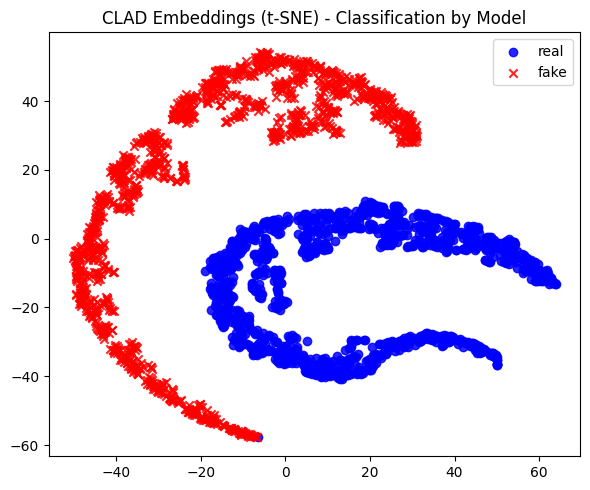

In [ ]:
#14 =========================================
# t-SNE Visualization of Embeddings
# =========================================
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# The 'rows' list is assumed to be available from the previous cell's execution
emb_rows = [r for r in rows if r["embedding"] is not None]

if len(emb_rows) >= 2:
    # Separate embeddings and predicted labels
    X = np.vstack([np.array(r["embedding"], dtype=np.float32) for r in emb_rows])
    y = np.array([r["pred"] for r in emb_rows])

    # Run t-SNE
    # Perplexity should be < N_samples.
    # Use 15 for your small dataset of ~2700 total samples (real+fake).
    perp = min(30, len(emb_rows)-1)
    print(f"Running t-SNE with perplexity={perp}...")

    # Trigger image generation for better visualization

    X2d = TSNE(n_components=2, random_state=0, perplexity=perp, init='random', learning_rate='auto').fit_transform(X)

    plt.figure(figsize=(6,5))
    for cls, marker, color in [("real", "o", "blue"), ("fake", "x", "red")]:
        mask = (y == cls)
        plt.scatter(X2d[mask,0], X2d[mask,1], label=cls, marker=marker, alpha=0.85, color=color)

    plt.title("CLAD Embeddings (t-SNE) - Classification by Model")
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No embeddings available (encoder not exposed or too few samples).")